In [40]:
import numpy as ny
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import scipy

# from scipy import stats
# import seaborn as sns

# filepath填S1，filepath2填S2/S3/S4C:\Users\coco\Desktop\0916-s1.xlsx
filepath = r"C:\Users\coco\Desktop\0922\0922-s1-1-v1.xlsx"
    
# Get the list of filepath(S1) in the Excel file
xls = pd.ExcelFile(filepath)
sheet_names = xls.sheet_names

# Create a dictionary to store the mappings of table number to DataFrame
table_data = {}
SZ22_maxs = []
MBC370_maxs = []
PAC1_maxs = []
# Iterate over each sheet and read the tables
for i, sheet_name in enumerate(sheet_names):
  
    table_number = i + 1
    df = pd.read_excel(filepath, sheet_name=sheet_name)
    del df['Slice.1']
    del df['Slice.2']
    
    df['Slice'] = df['Slice'] * 10
    df.rename (
        columns ={"Slice":"Time","Mean":"SZ22_raw_indensity","Mean.1":"MBC370_raw_indensity", "Mean.2":"PAC1_raw_indensity"},
        inplace = True,
    )
    
# boolean indexing to remove NaN ， isna=ture, ~与逻辑相反 --> isna=false, 仅仅保留ture且其行跟着索引
    mask = df['SZ22_raw_indensity'].isna()
    df = df[~mask] 
    
    mask = df['Time'].isna()
    df = df[~mask] 

#     算所有sheet单项最大值-
    SZ22_max = df["SZ22_raw_indensity"].max()
    SZ22_maxs.append(SZ22_max)
    
    MBC370_max = df["MBC370_raw_indensity"].max()
    MBC370_maxs.append(MBC370_max)

    PAC1_max = df["PAC1_raw_indensity"].max()
    PAC1_maxs.append(PAC1_max)
    
    table_data[f"Table{table_number}"] = df  

SZ22_maxAvg = sum(SZ22_maxs) / len(SZ22_maxs)
MBC370_maxAvg = sum(MBC370_maxs) / len(MBC370_maxs)
PAC1_maxAvg = sum(PAC1_maxs) / len(PAC1_maxs)



In [56]:
# Get the list of S2/S3/S4 in the Excel file
filepath2 = r"C:\Users\coco\Desktop\0922\0922-s1-2-v1.xlsx"

xls2 = pd.ExcelFile(filepath2)
sheet_names = xls2.sheet_names

# Iterate over each sheet and read the tables
for i, sheet_name in enumerate(sheet_names):
  
    table_number = i + 1
    df = pd.read_excel(filepath2, sheet_name=sheet_name)
    del df['Slice.1']
    del df['Slice.2']
    
    df['Slice'] = df['Slice'] * 10
    df.rename (
        columns ={"Slice":"Time","Mean":"SZ22_raw_indensity","Mean.1":"MBC370_raw_indensity", "Mean.2":"PAC1_raw_indensity"},
        inplace = True,
    )
    
# boolean indexing to remove NaN ， isna=ture, ~与逻辑相反 --> isna=false, 仅仅保留ture且其行跟着索引
    mask = df['SZ22_raw_indensity'].isna()
    df = df[~mask] 
    
    mask = df['Time'].isna()
    df = df[~mask] 

    table_data[f"Table{table_number}"] = df  

for table_number, df in table_data.items():
    SZ22_Normalization = (df["SZ22_raw_indensity"] + 0.00 * SZ22_maxAvg) / (SZ22_maxAvg + 0.00 * SZ22_maxAvg)
    df['SZ22 Normalization'] = SZ22_Normalization
    
    MBC370_Normalization = (df["MBC370_raw_indensity"] + 0.00* MBC370_maxAvg)/  (MBC370_maxAvg + 0.00* MBC370_maxAvg)
    df['MBC370 Normalization'] = MBC370_Normalization
    
    PAC1_Normalization = (df["PAC1_raw_indensity"] + 0.05 * PAC1_maxAvg) / (PAC1_maxAvg + 0.05 * PAC1_maxAvg)
    df['PAC1 Normalization'] = PAC1_Normalization  
    

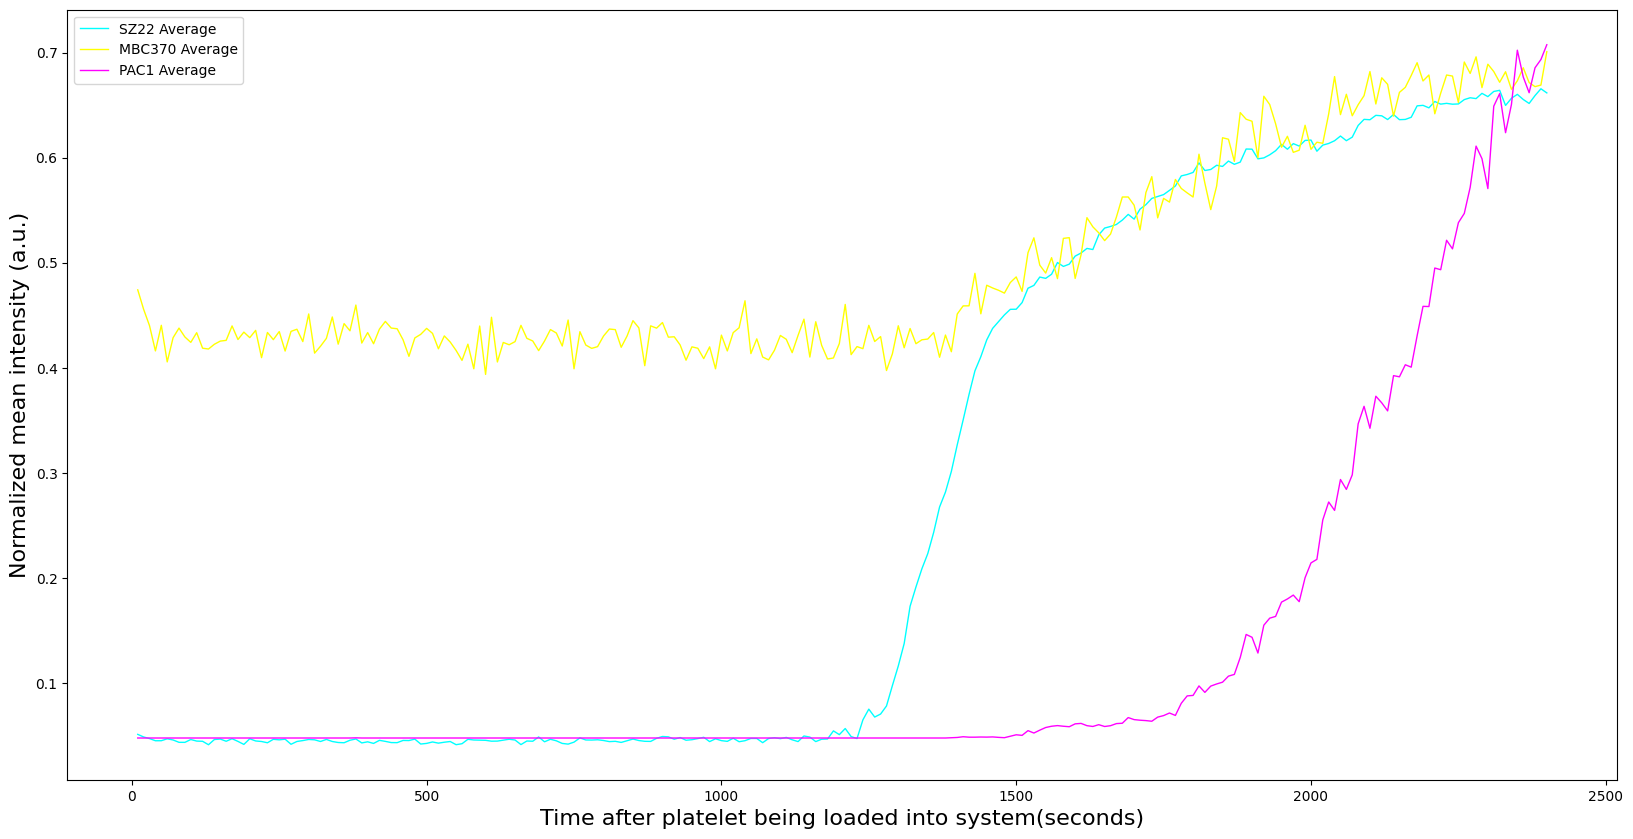

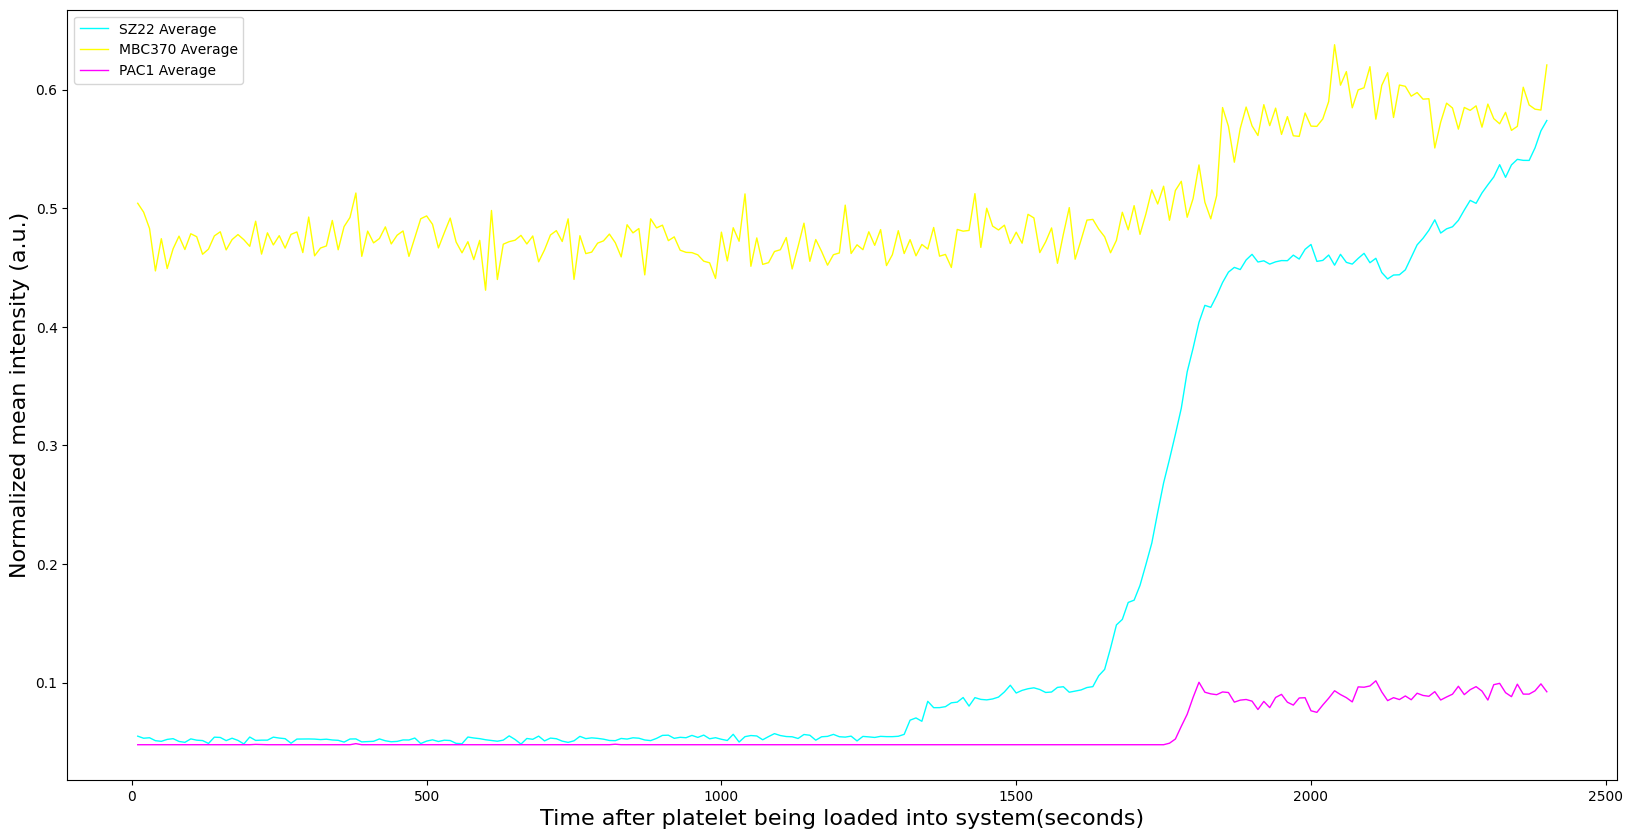

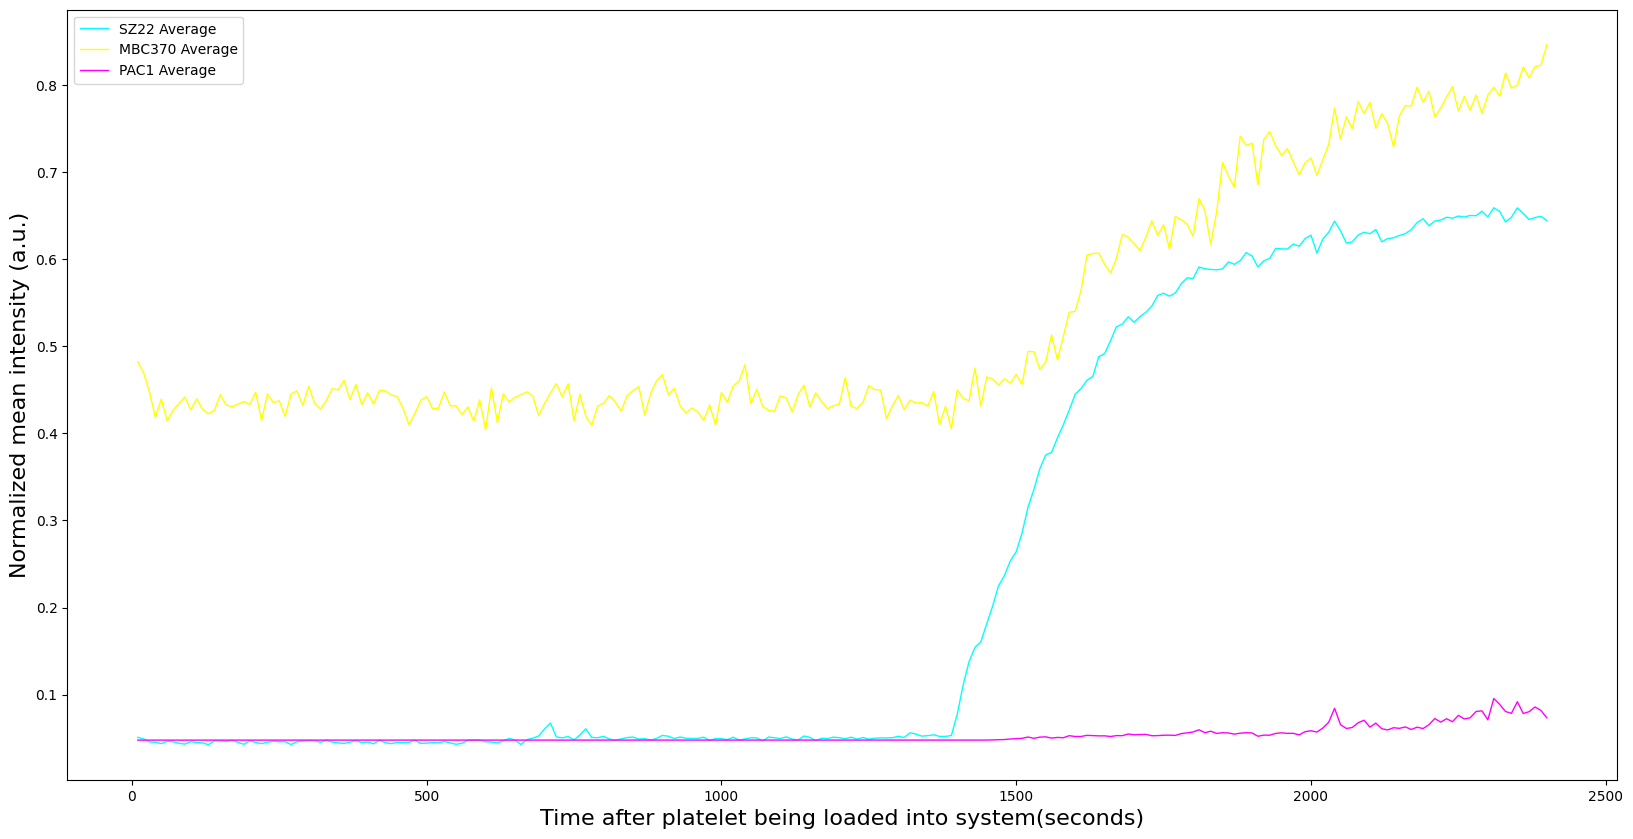

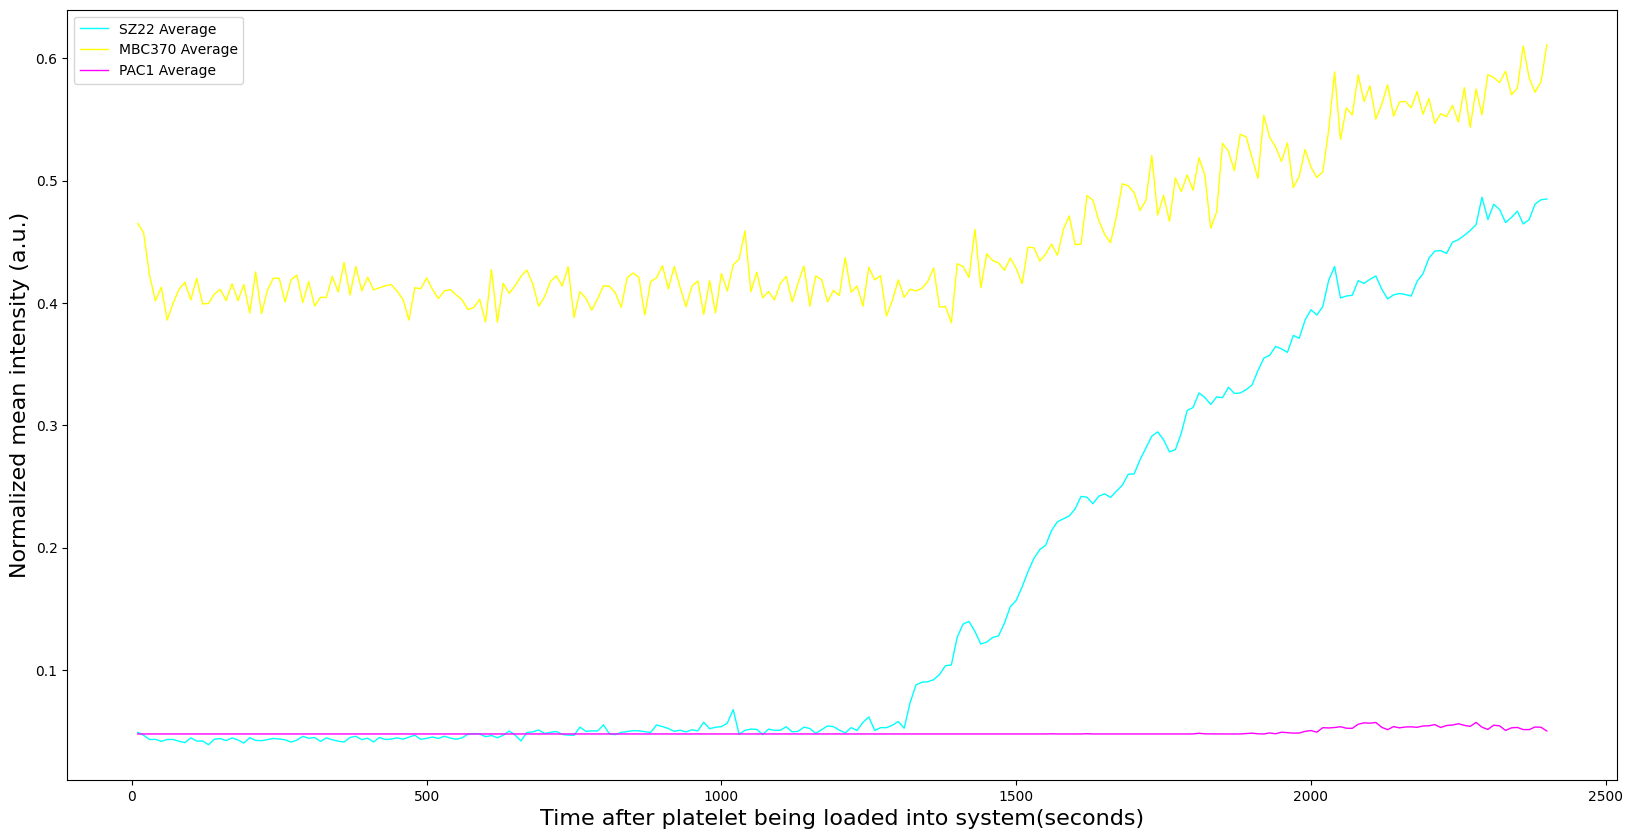

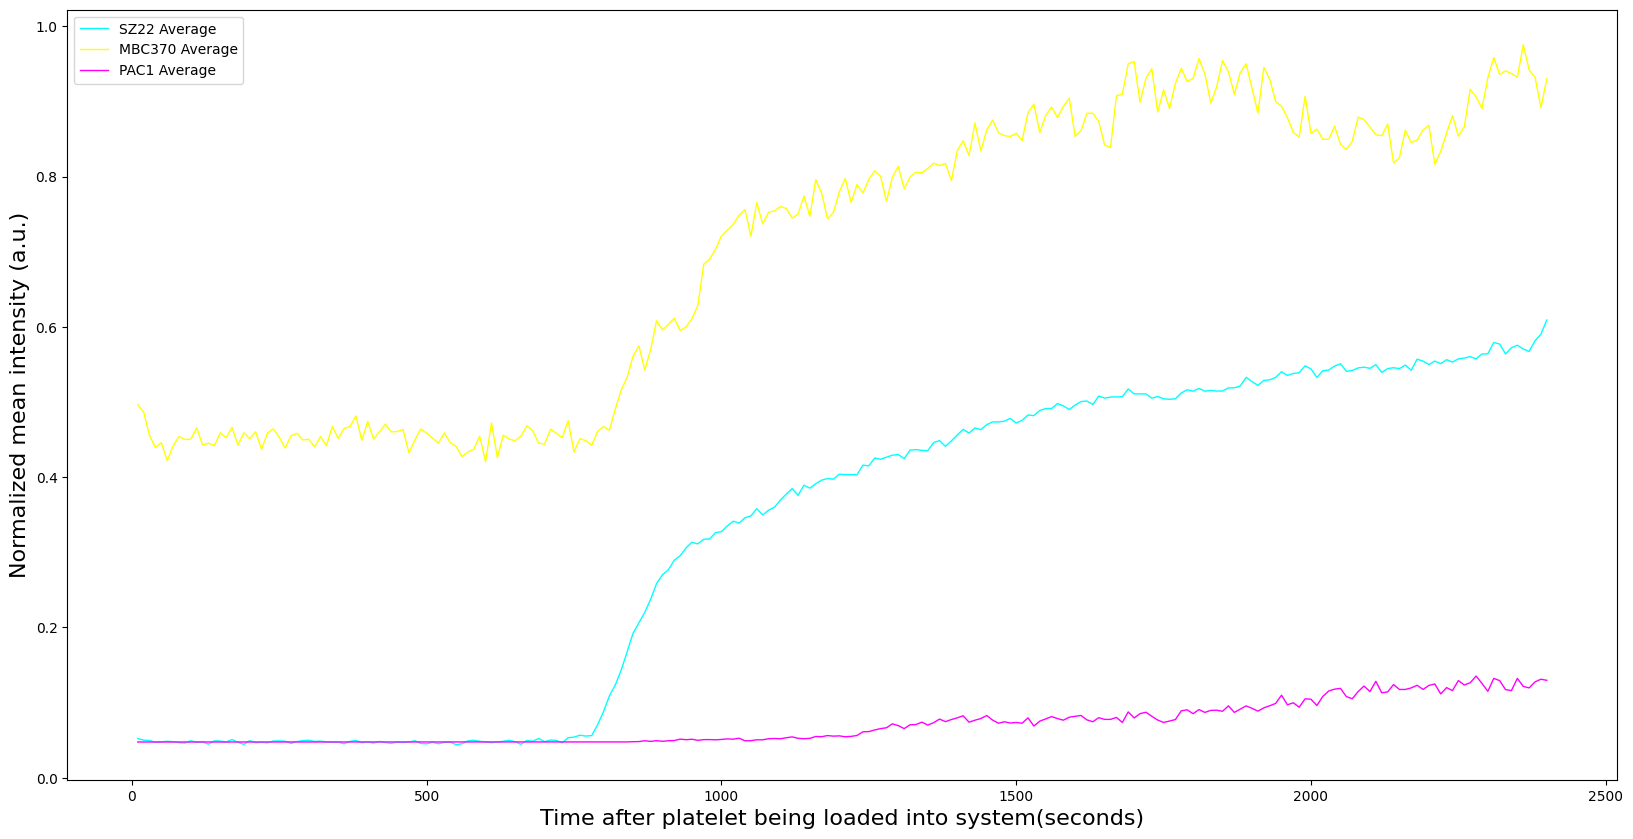

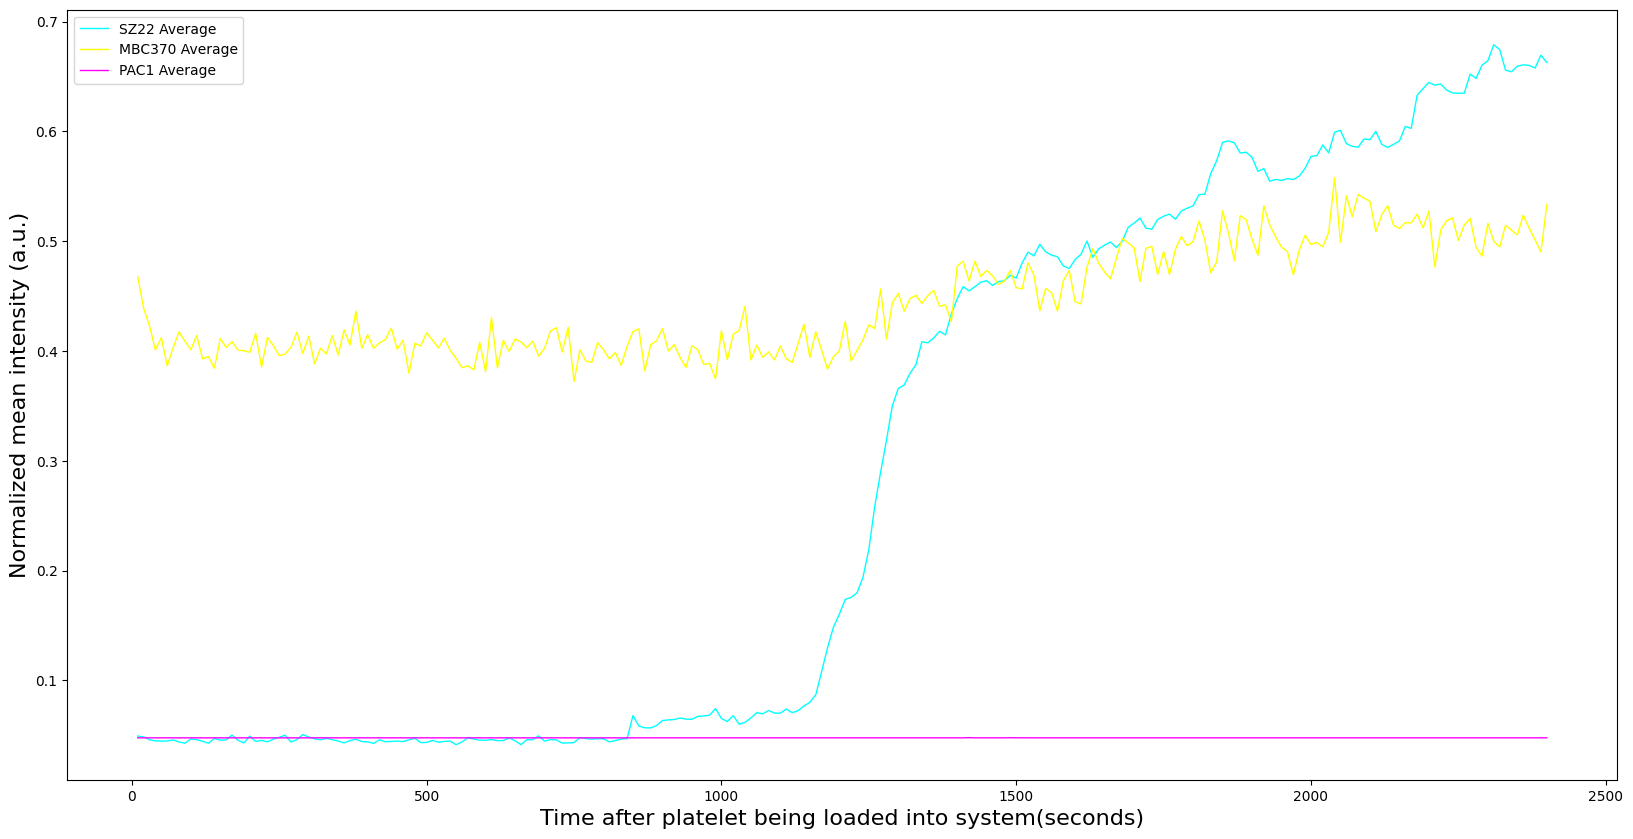

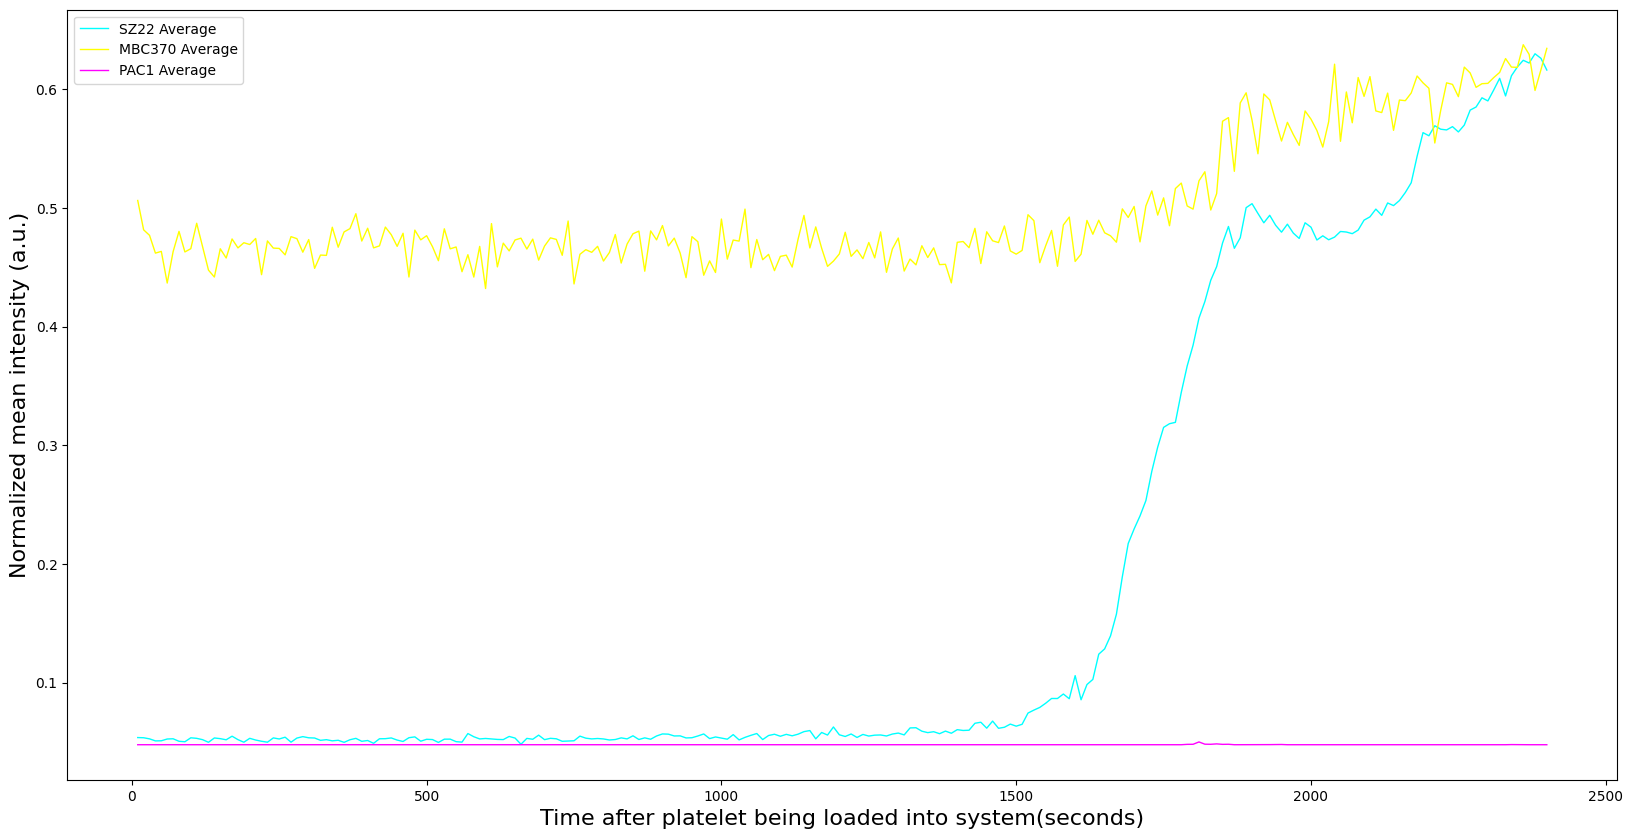

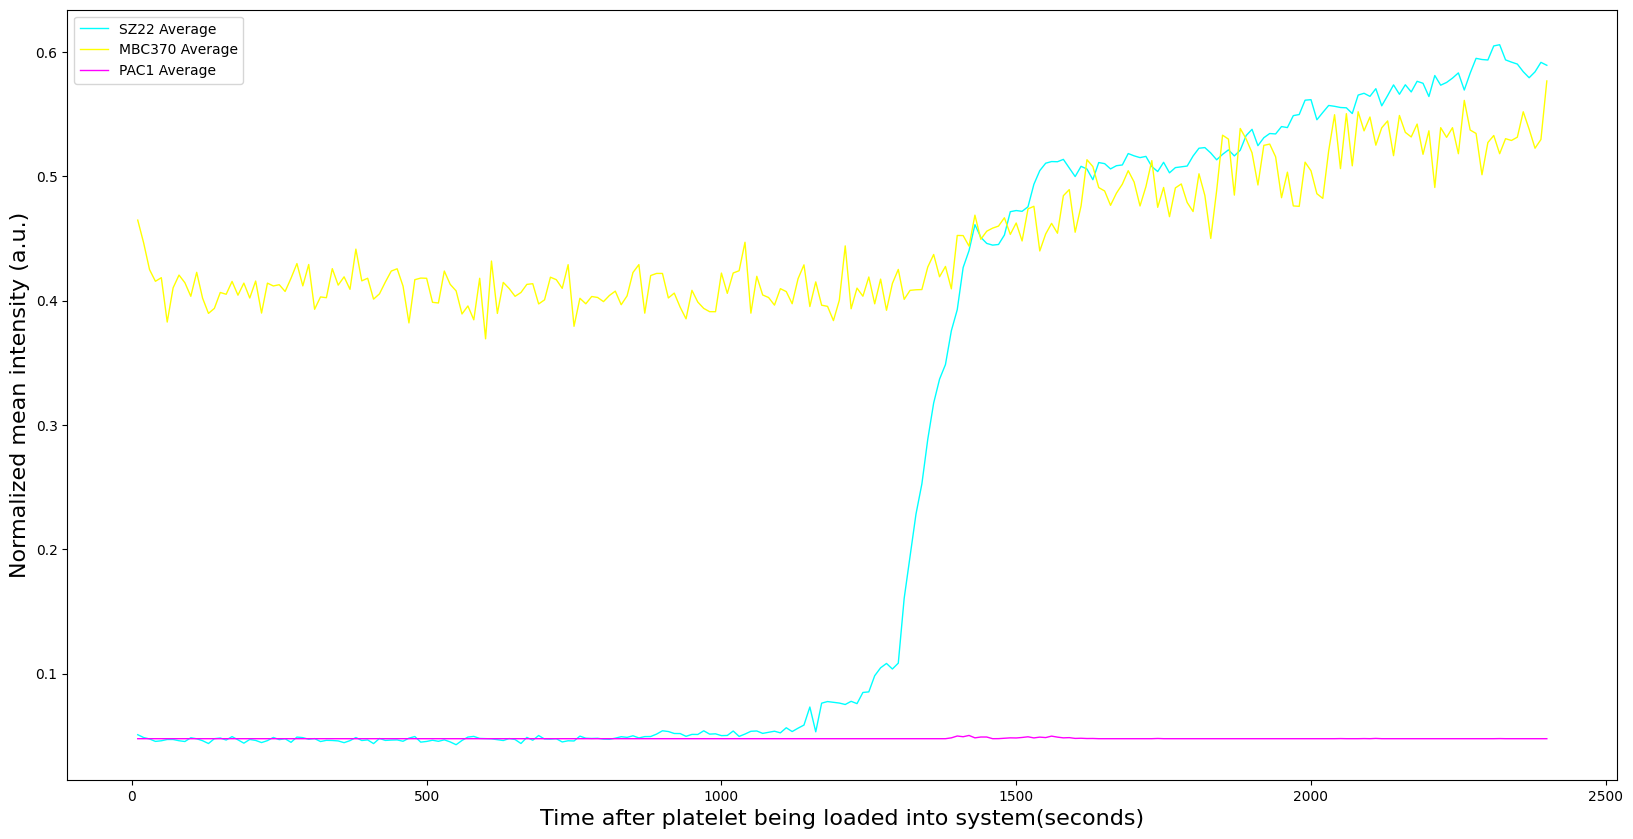

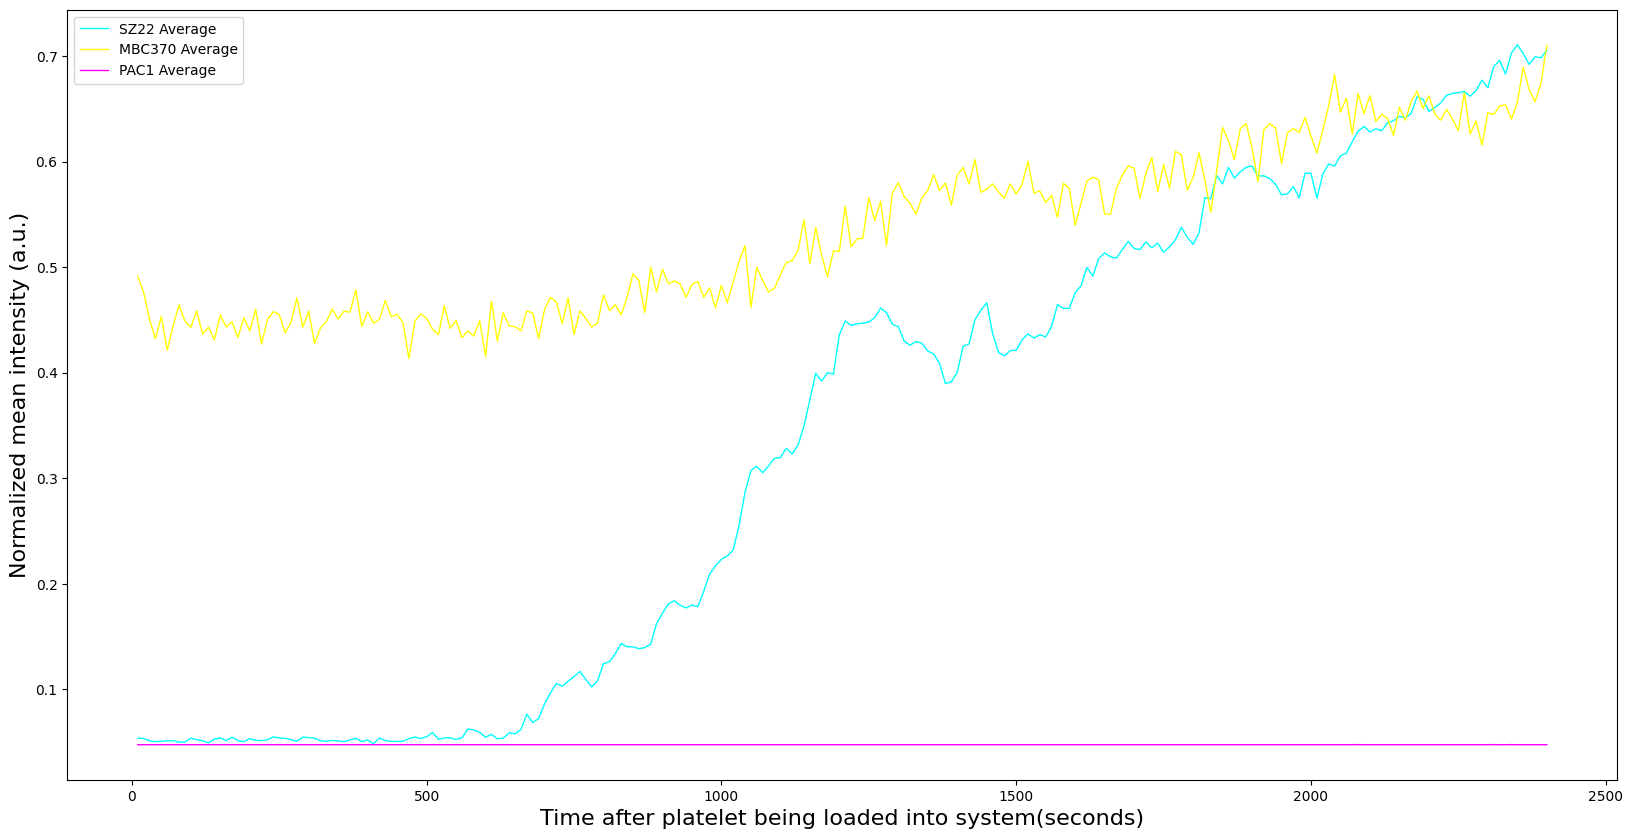

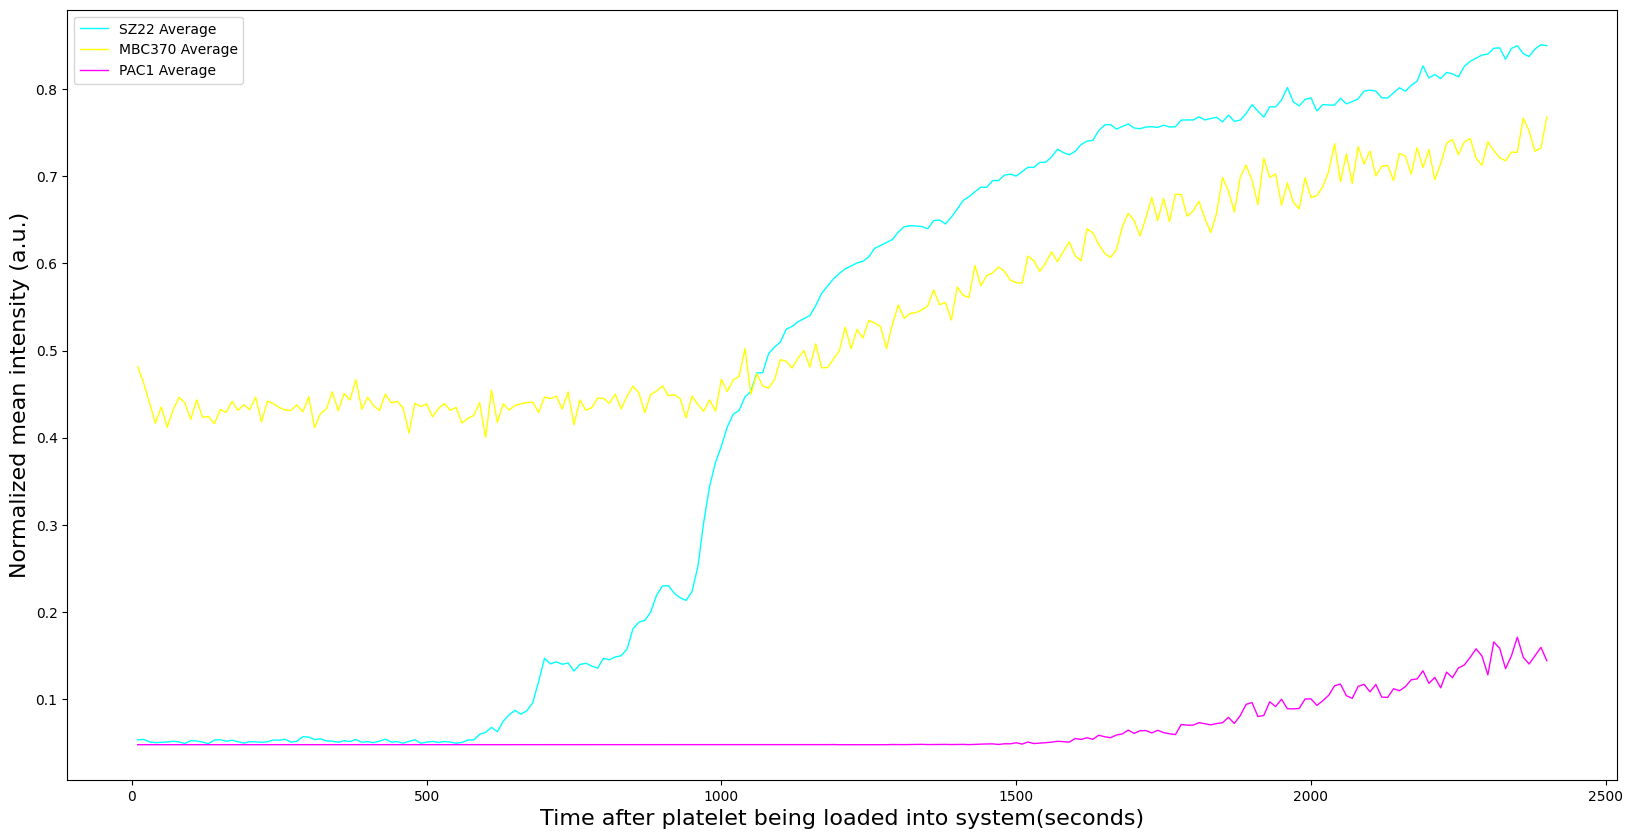

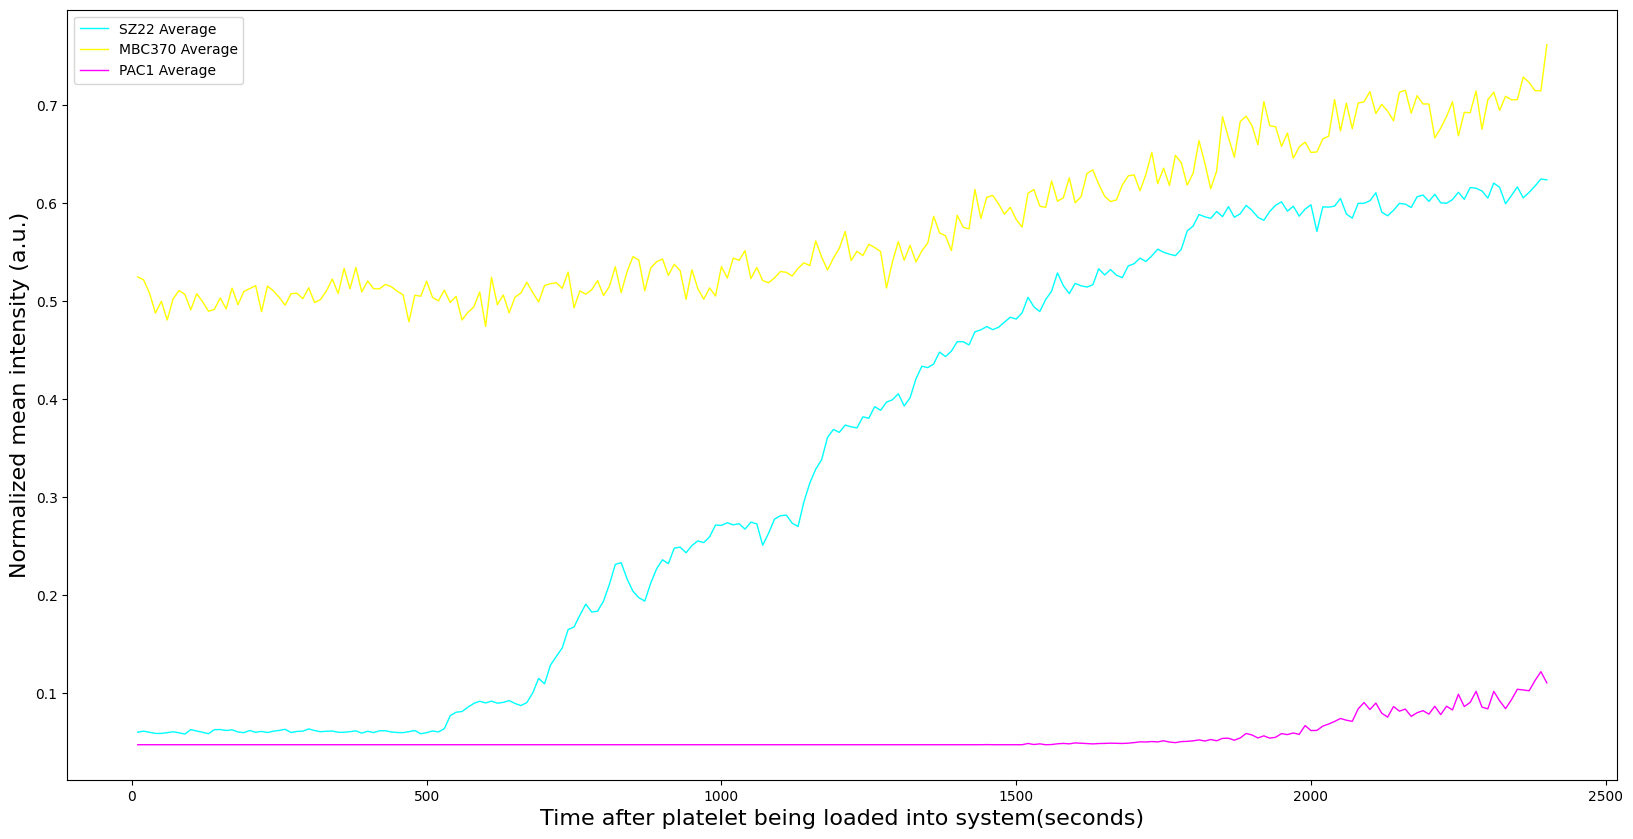

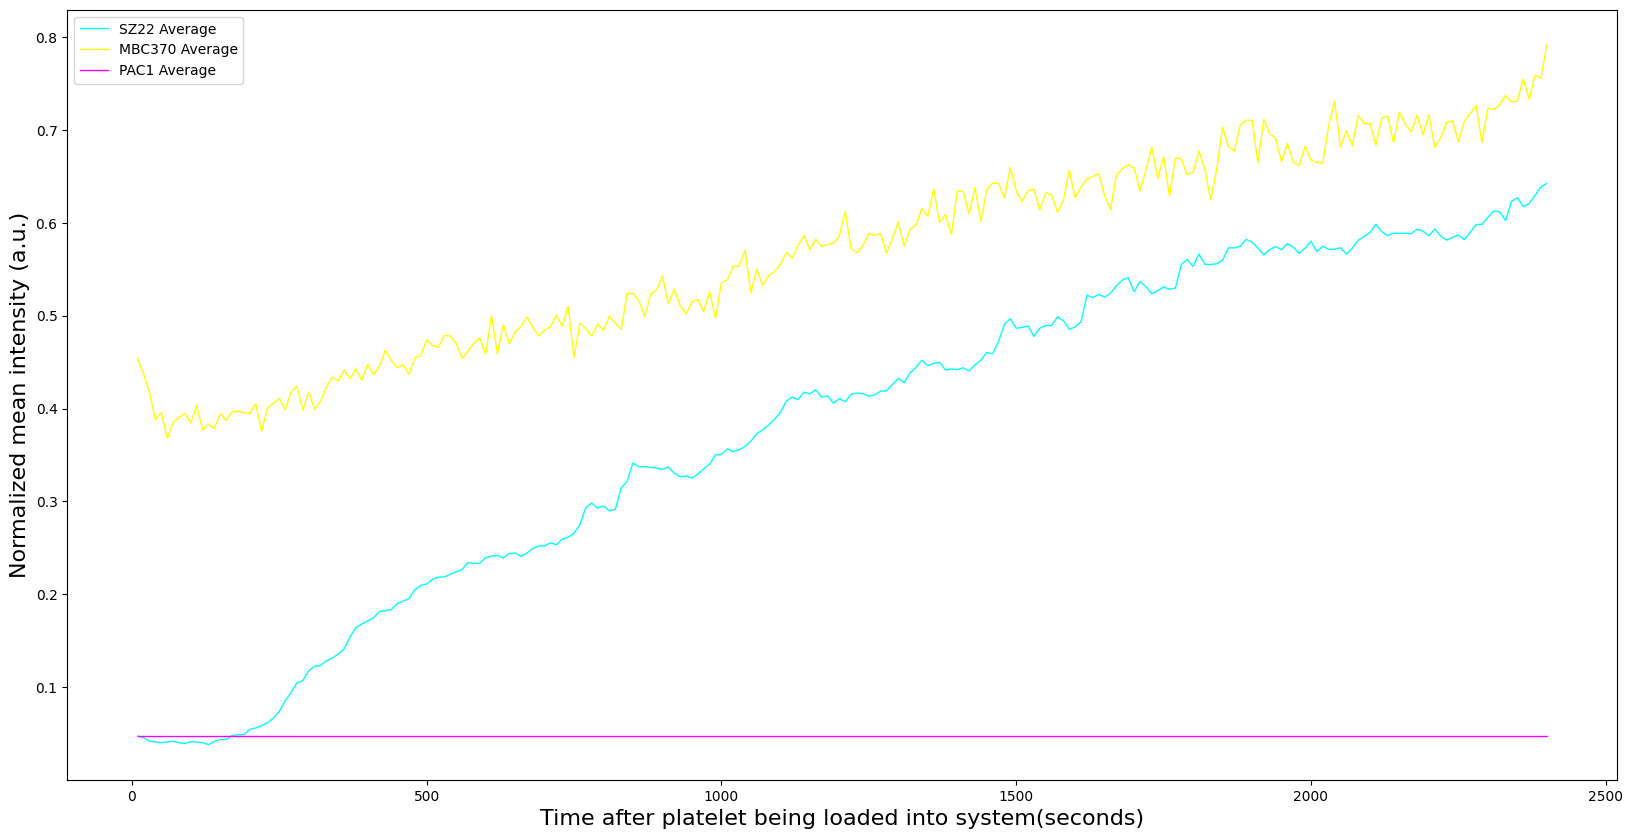

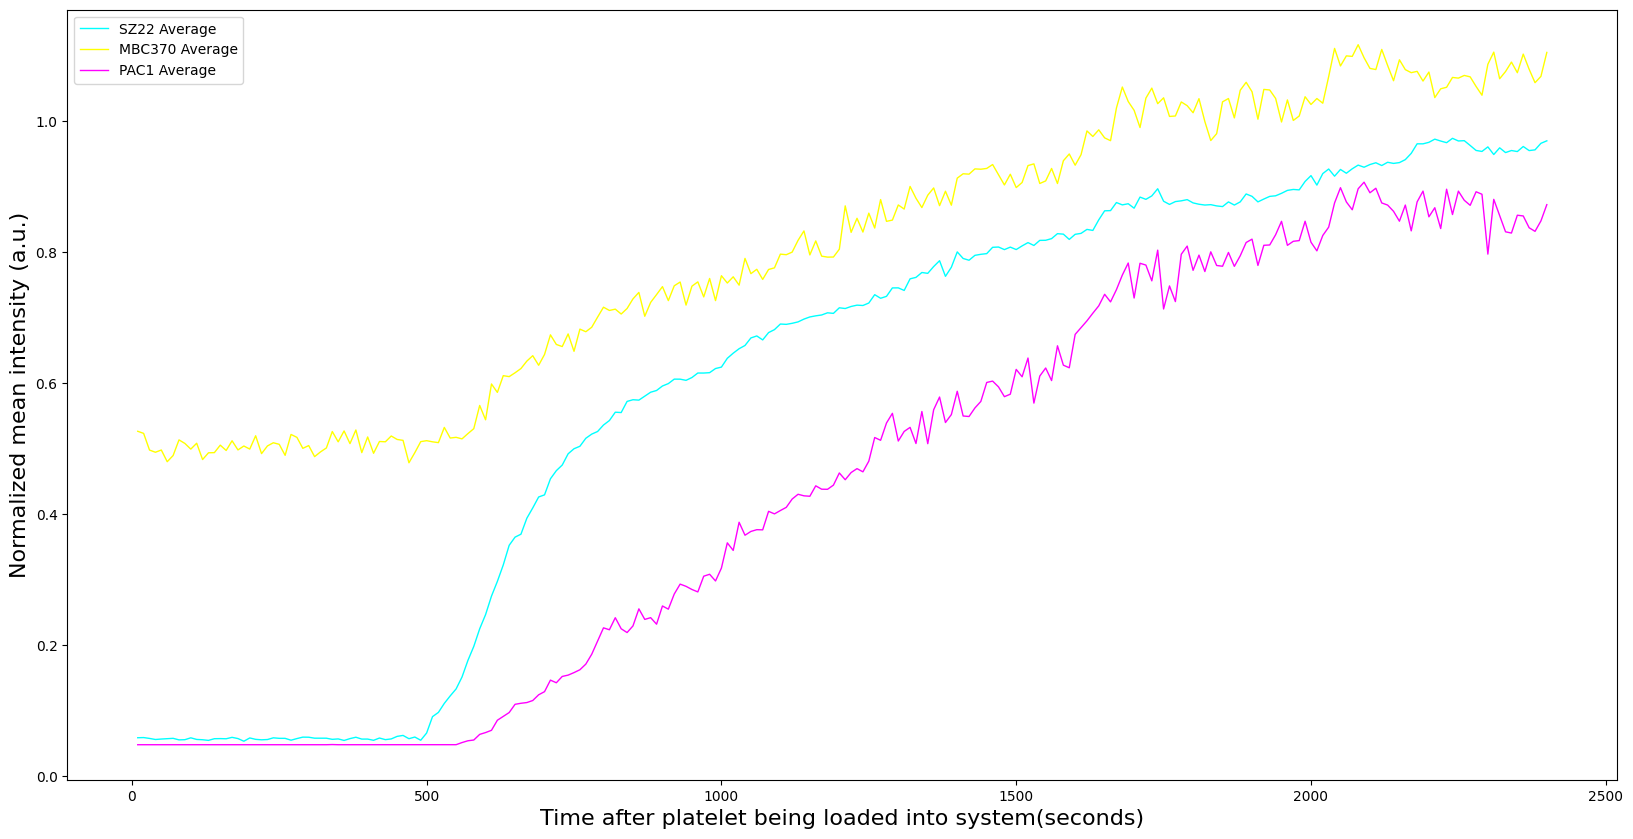

In [57]:
# 画表格，检查图片
for table_number, df in table_data.items():
    y1 = df["SZ22 Normalization"]
    y2 = df["MBC370 Normalization"]
    y3 = df["PAC1 Normalization"]
    x = df["Time"]
    
    
    plt.figure(figsize=(20,10))
    plt.plot(x,y1,c='cyan',label='SZ22 Average',linewidth=1.0)
    plt.plot(x,y2,c='yellow',label = 'MBC370 Average',linewidth=1.0)
    plt.plot(x,y3,c='magenta',label = 'PAC1 Average',linewidth=1.0)
    plt.xlabel("Time after platelet being loaded into system(seconds)", fontdict={'size': 16})
    plt.ylabel("Normalized mean intensity (a.u.)", fontdict={'size': 16})
    plt.legend(loc = 'best')
    plt.show()

[102.0, 42.0, 29.0, 60.0, 82.0, 90.0, 108.0, 95.0, 67.0, 68.0, 56.0, 15.0, 41.0]
65.76923076923077


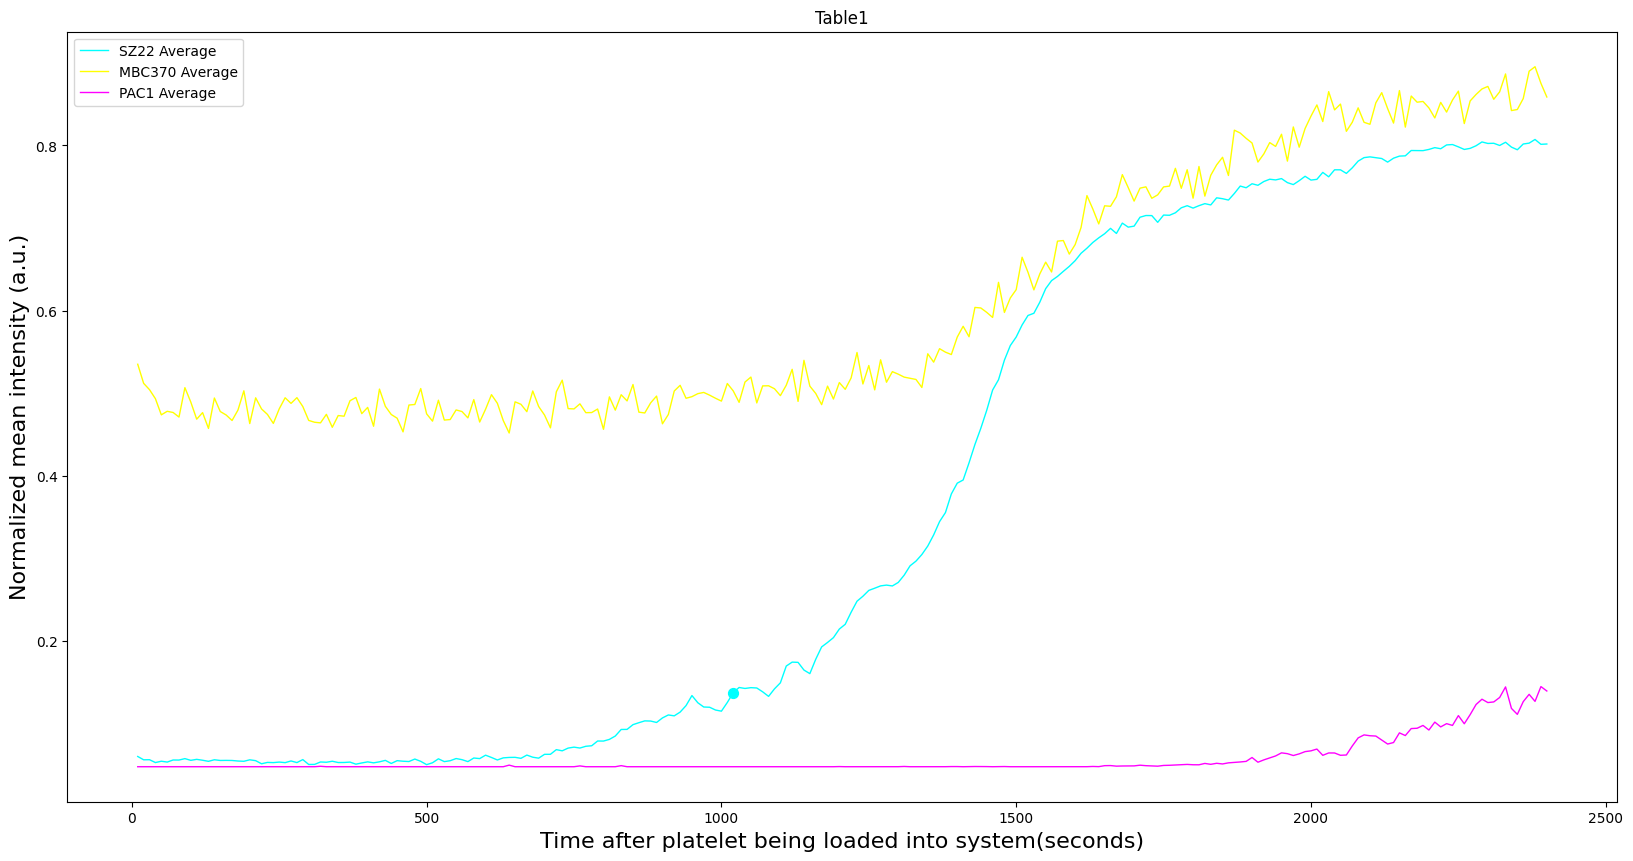

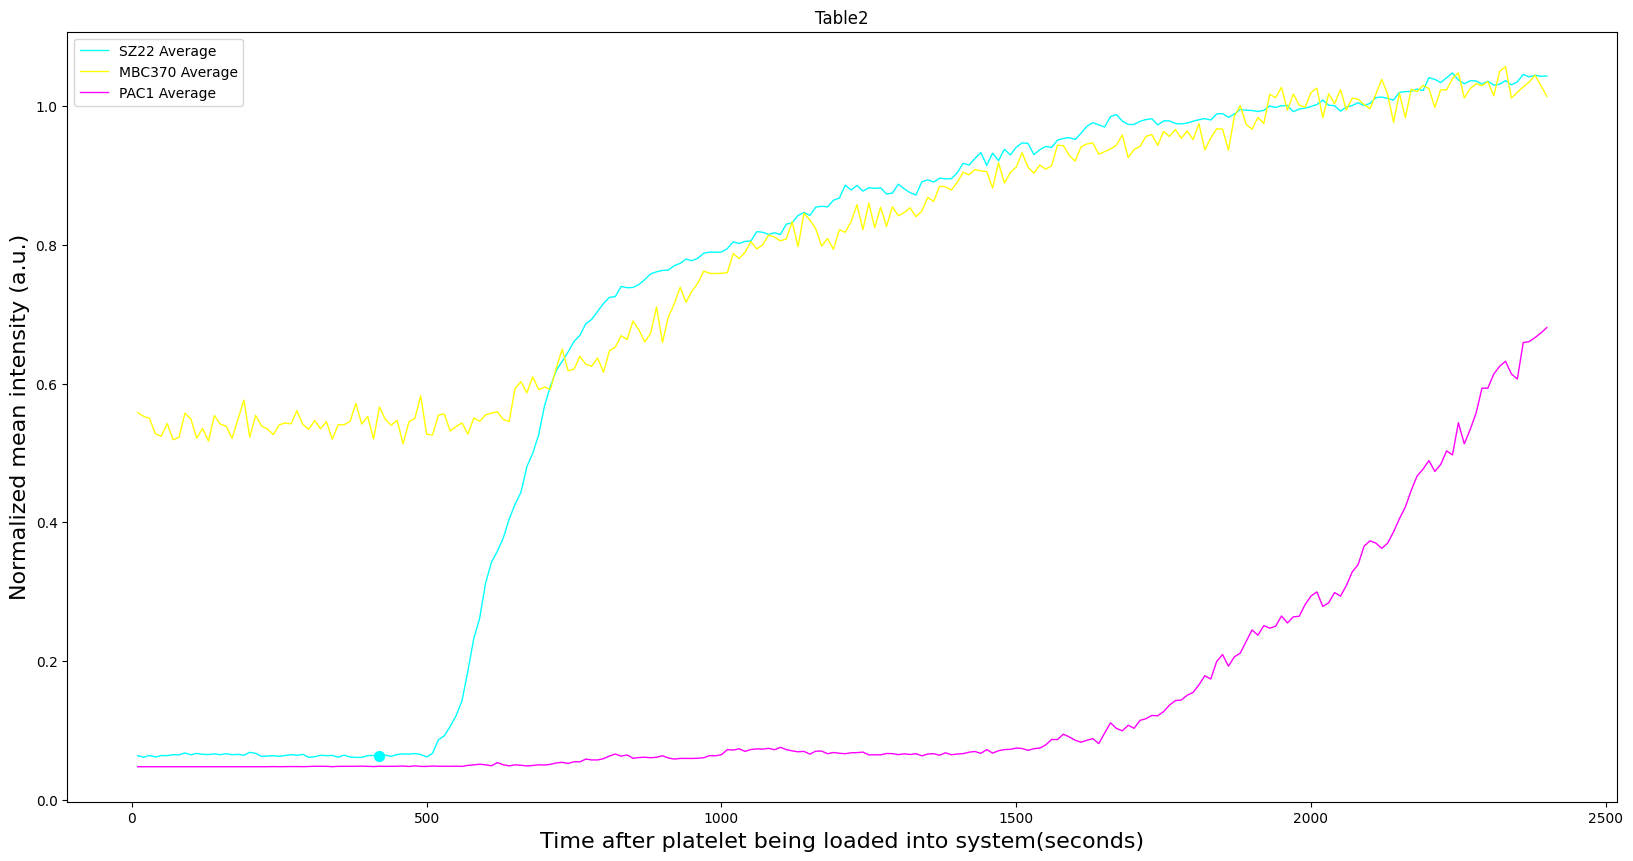

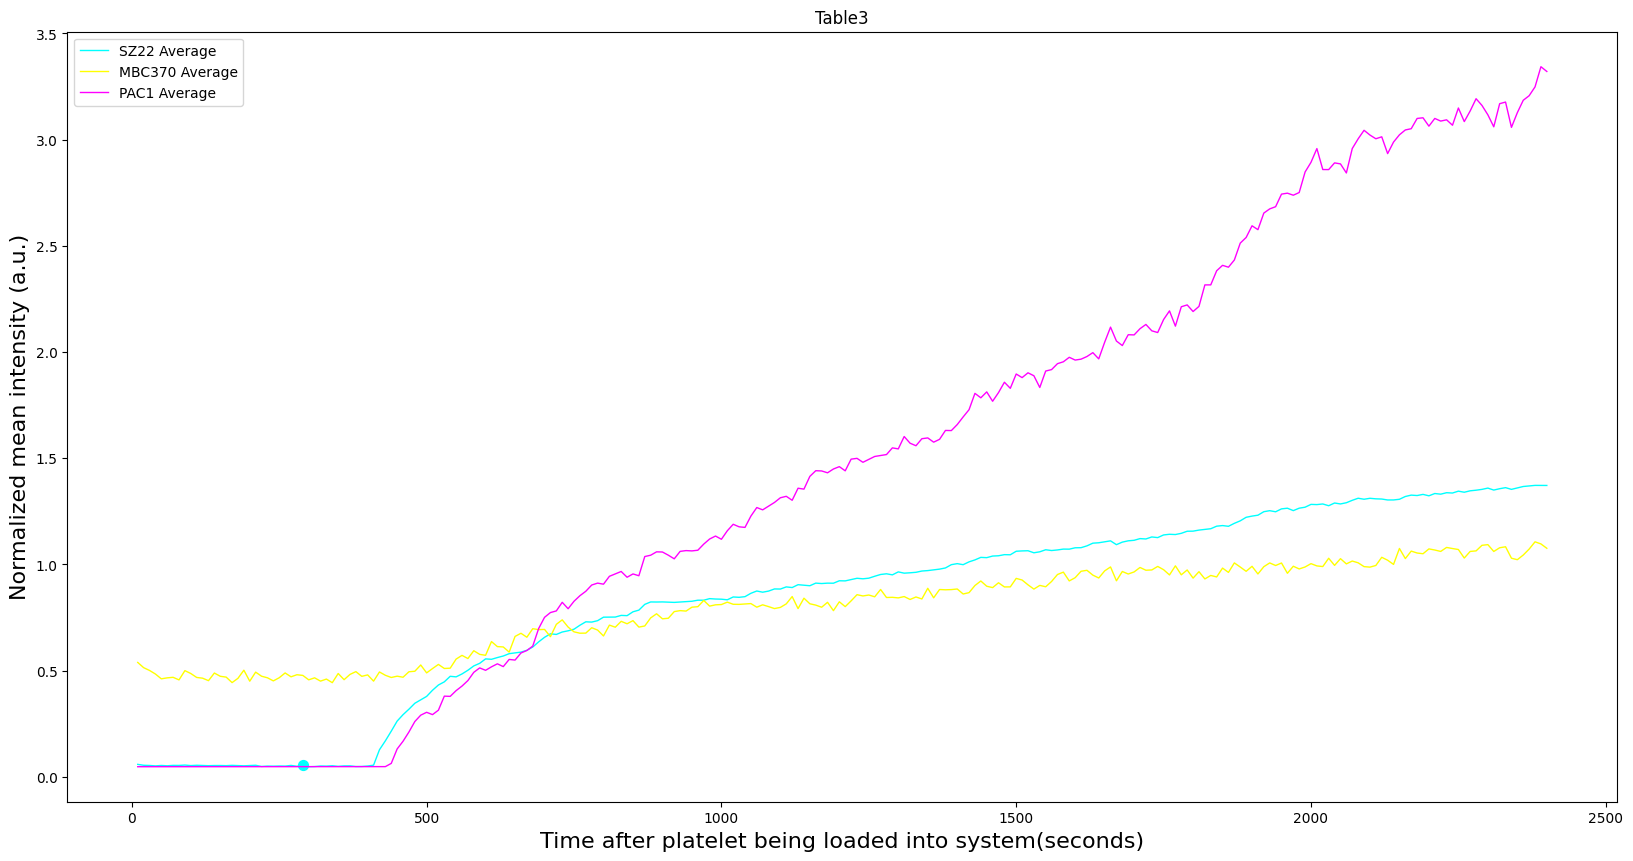

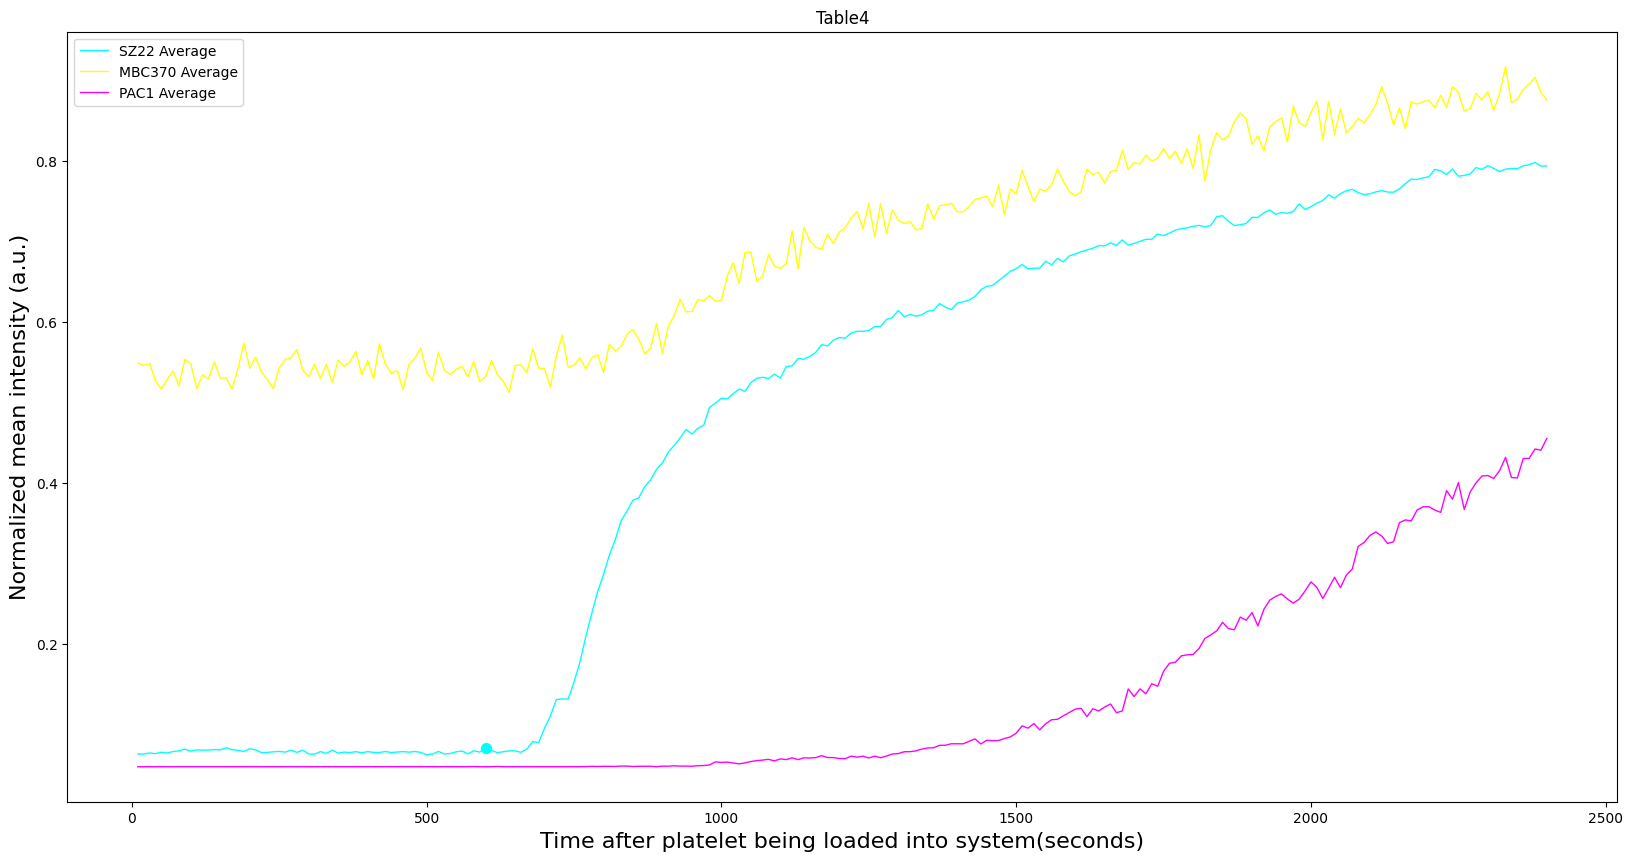

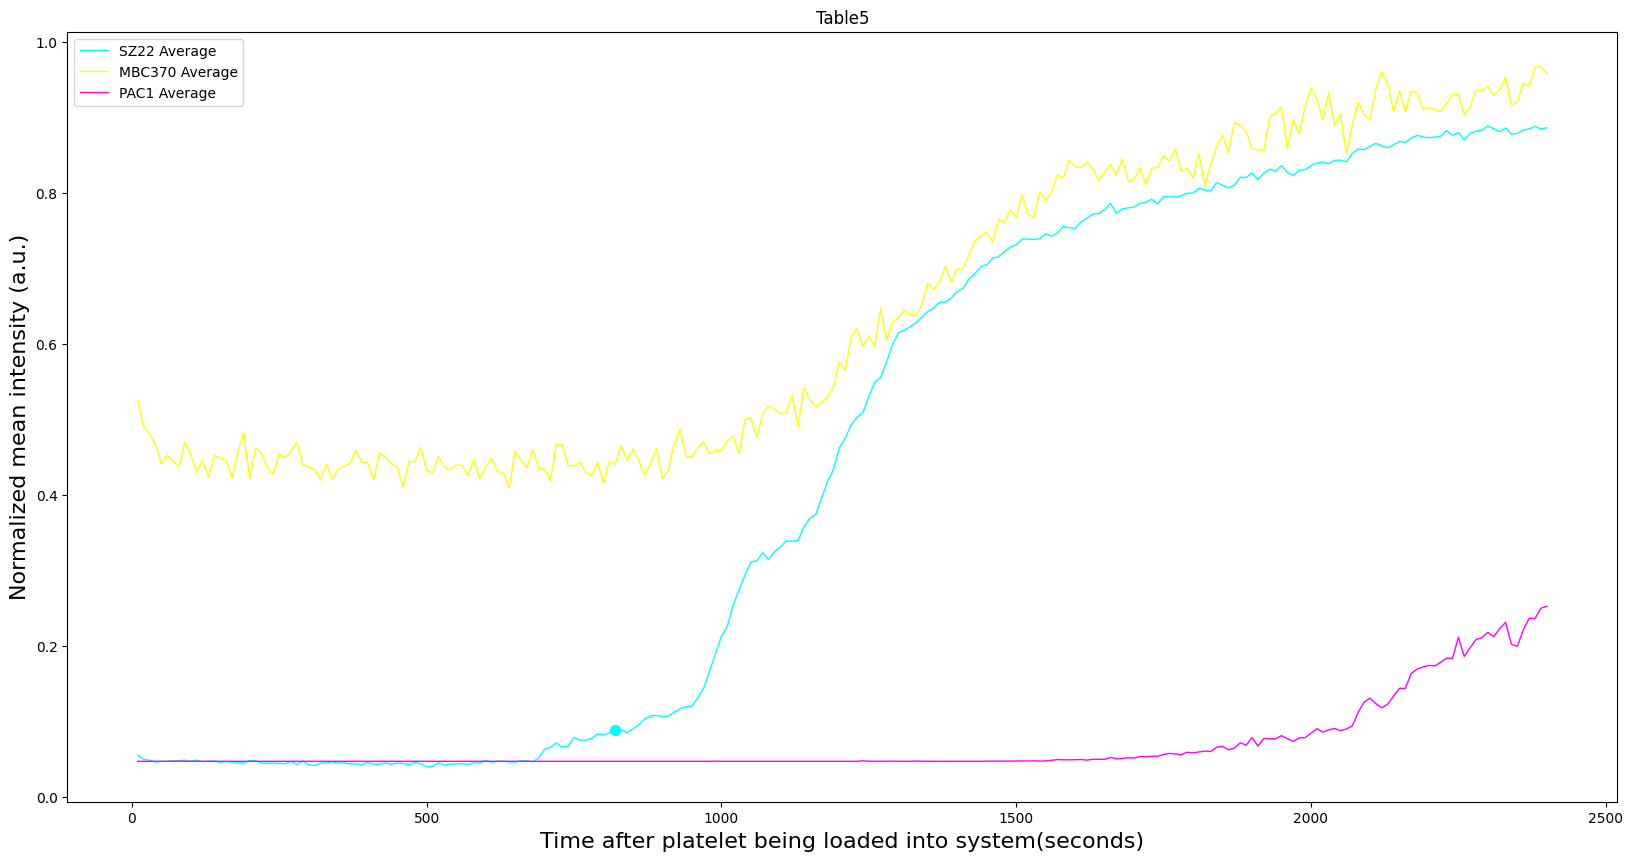

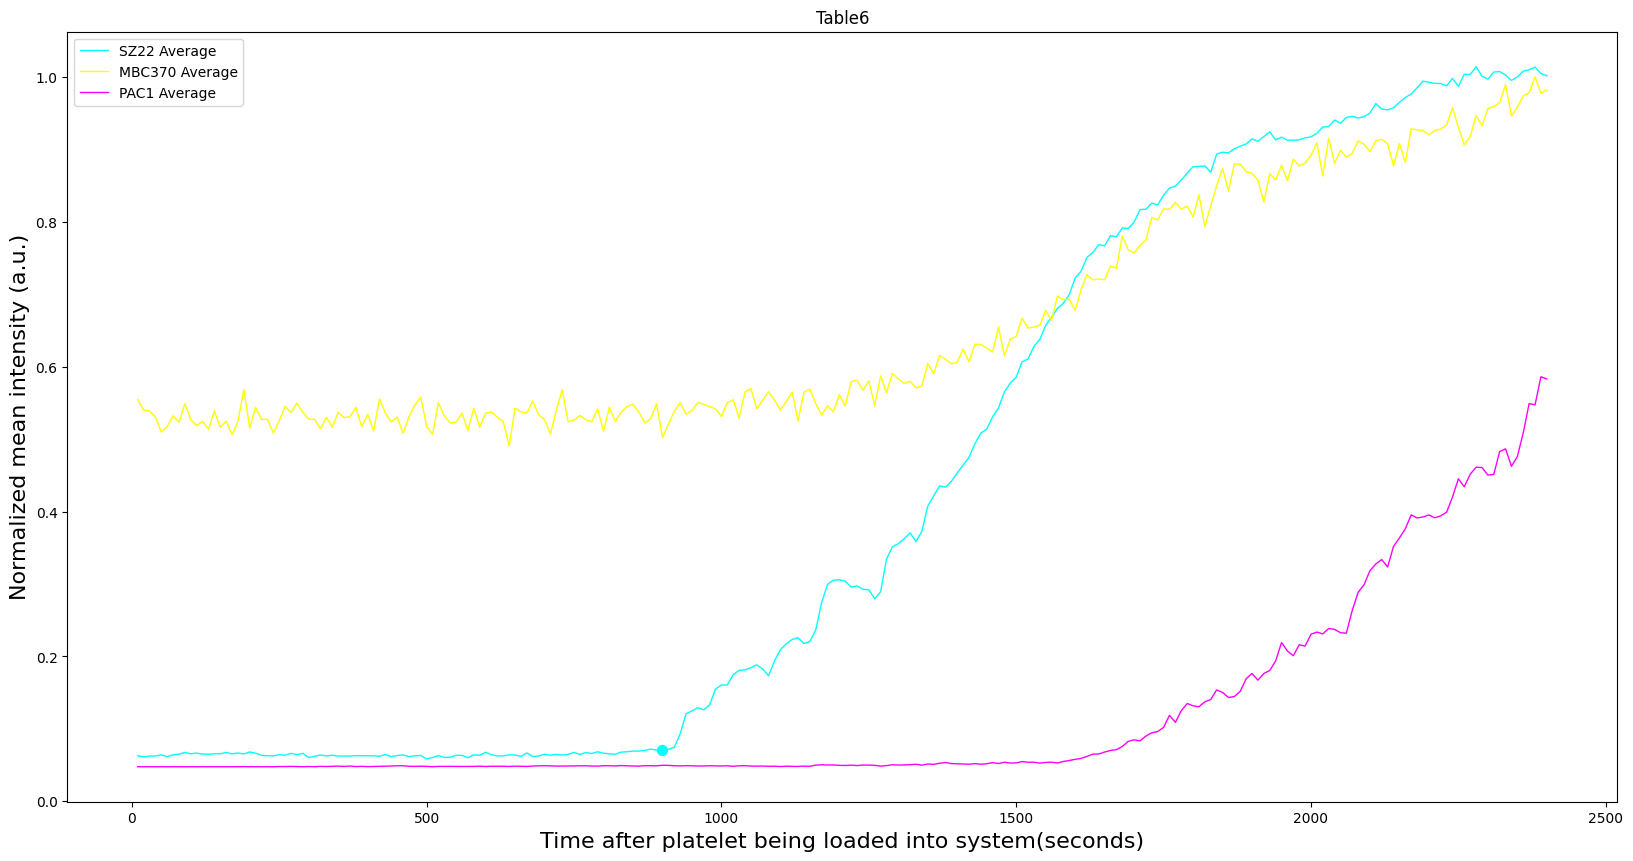

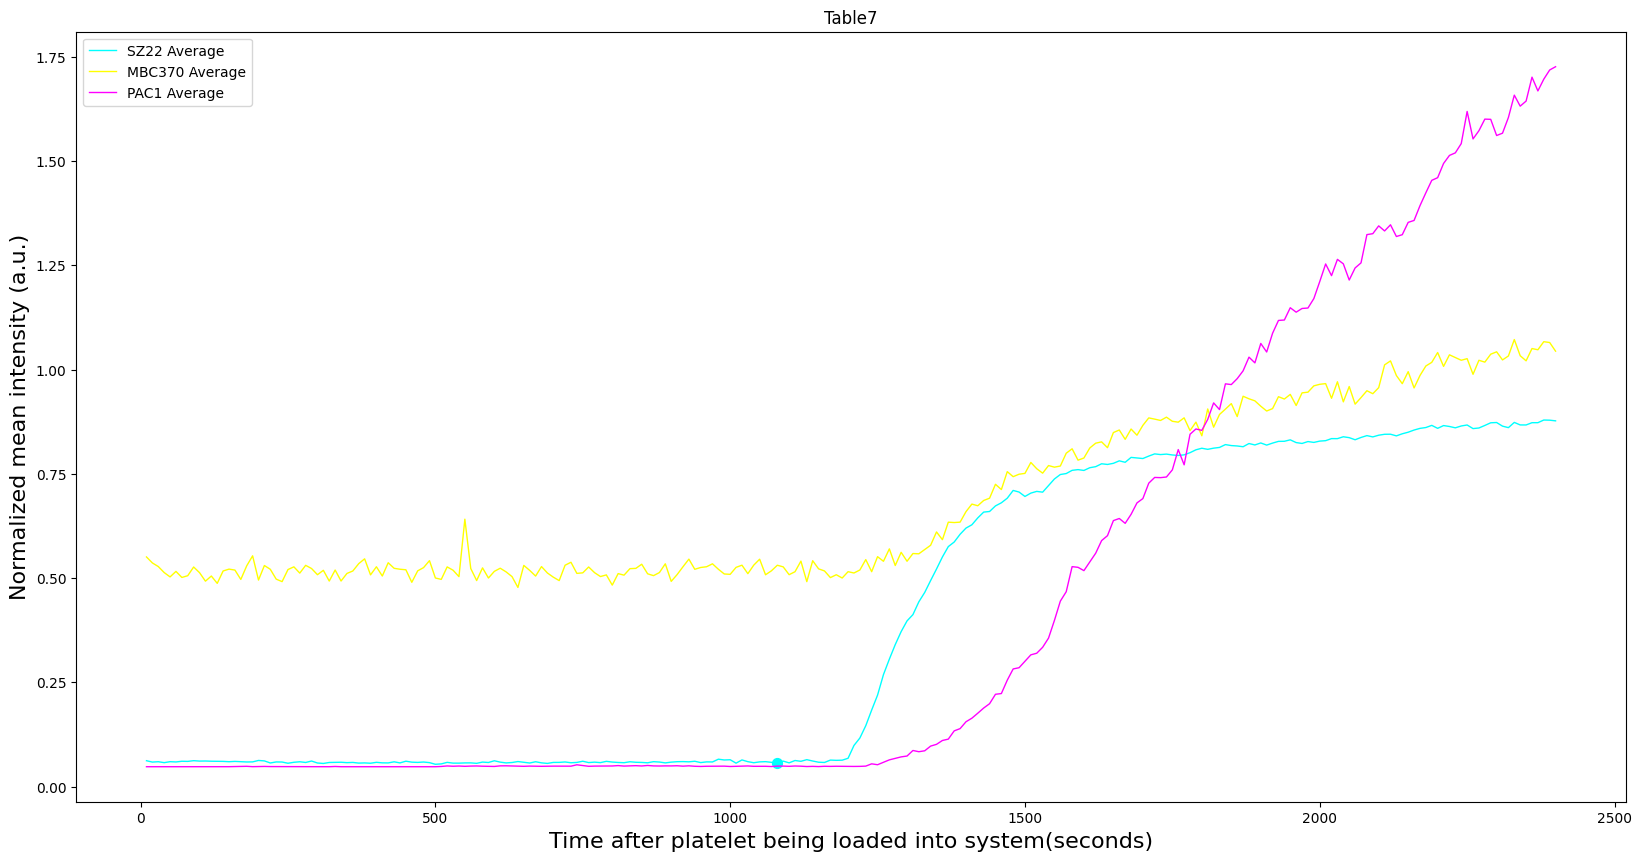

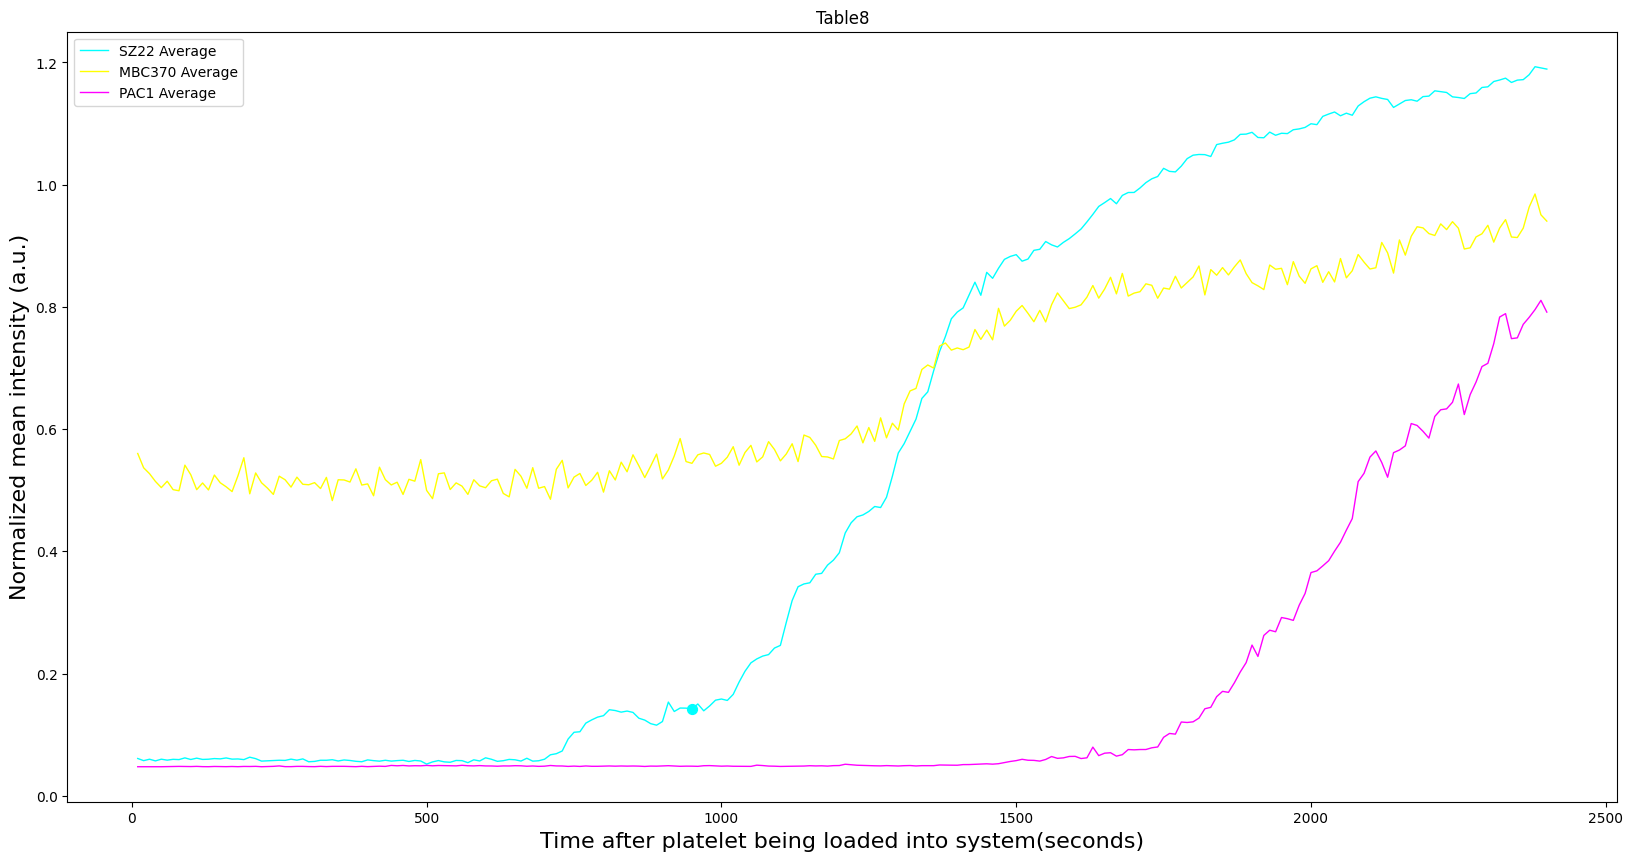

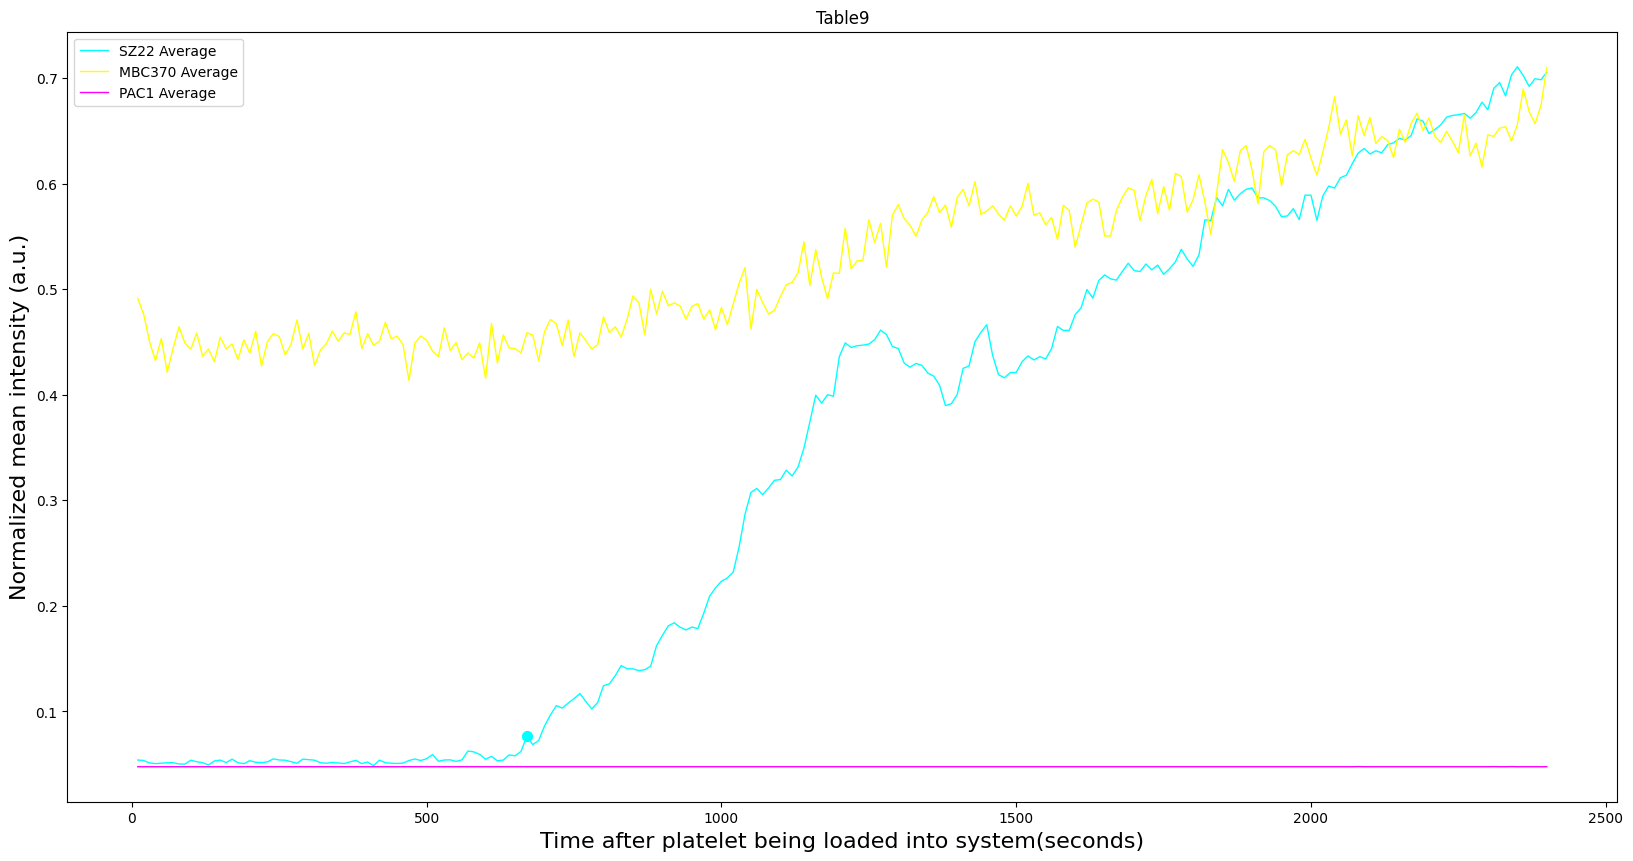

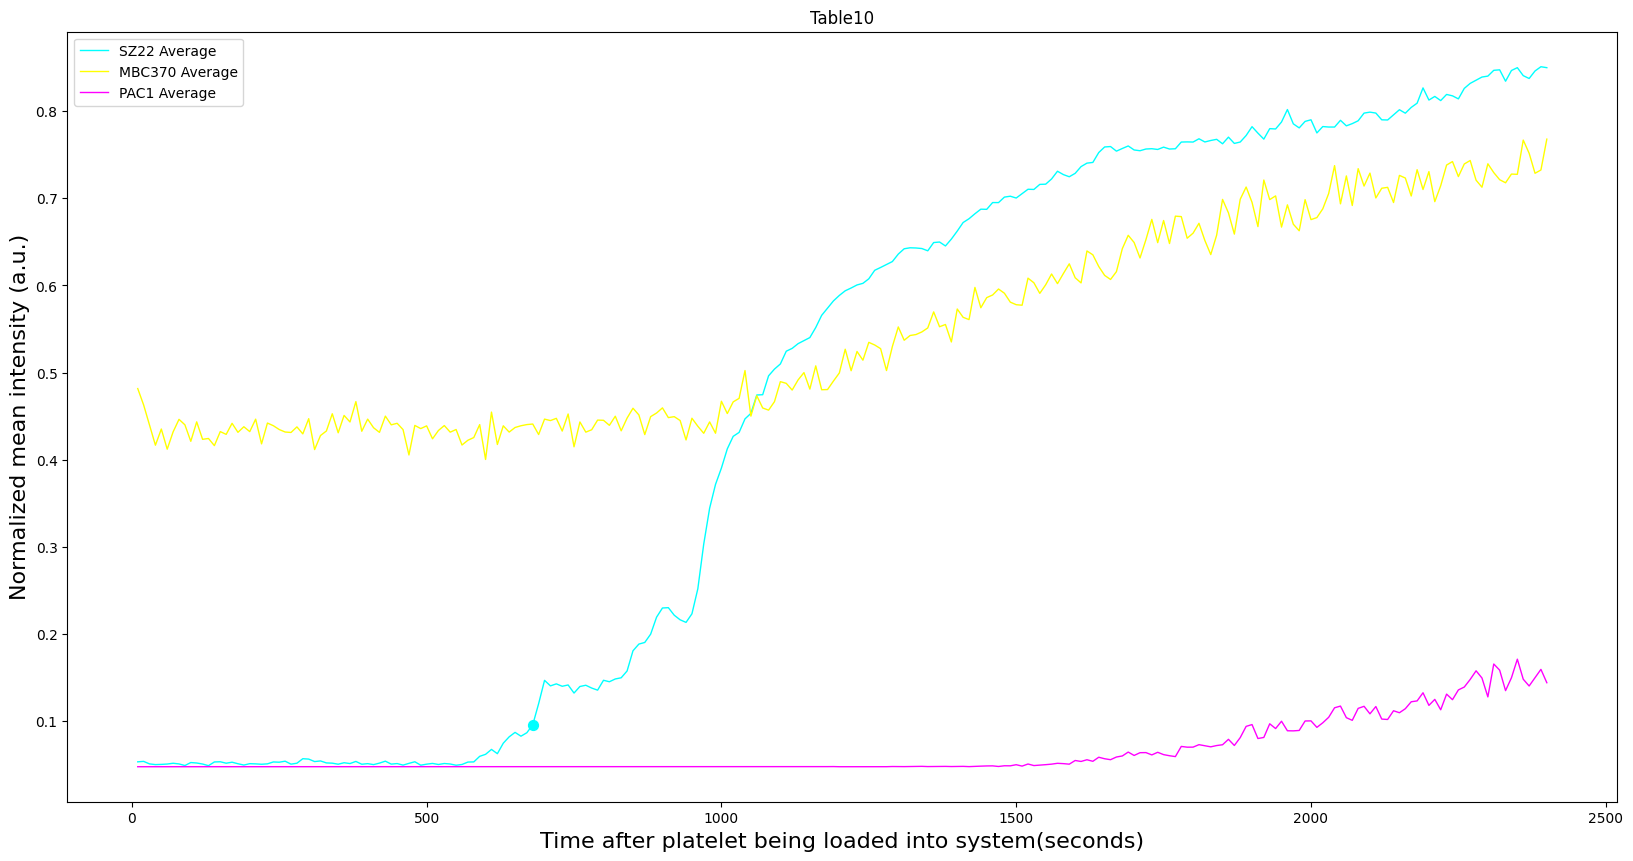

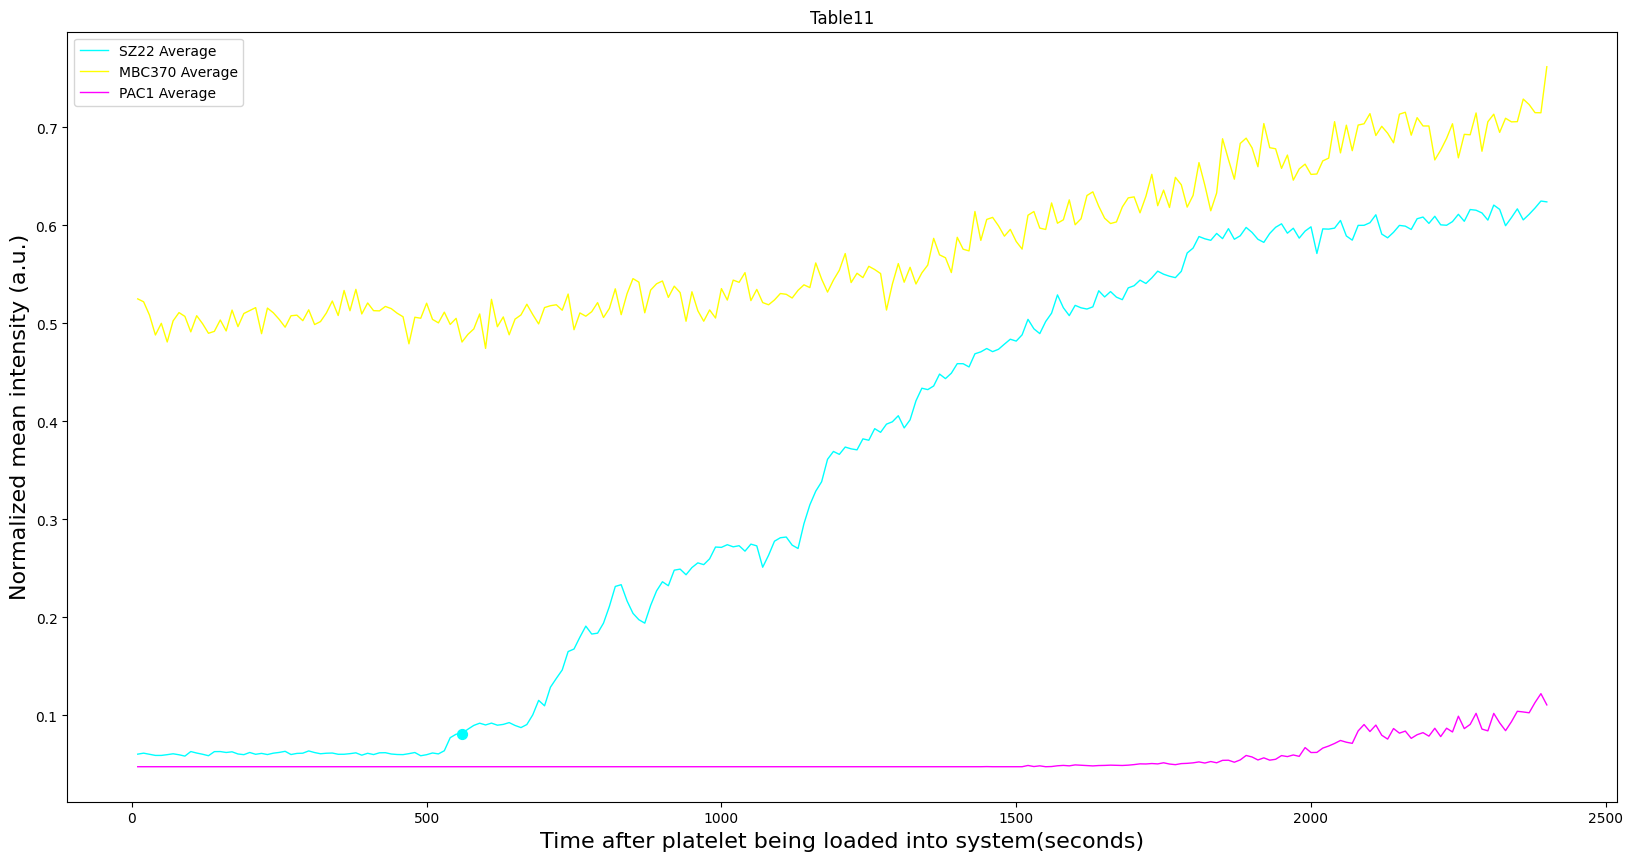

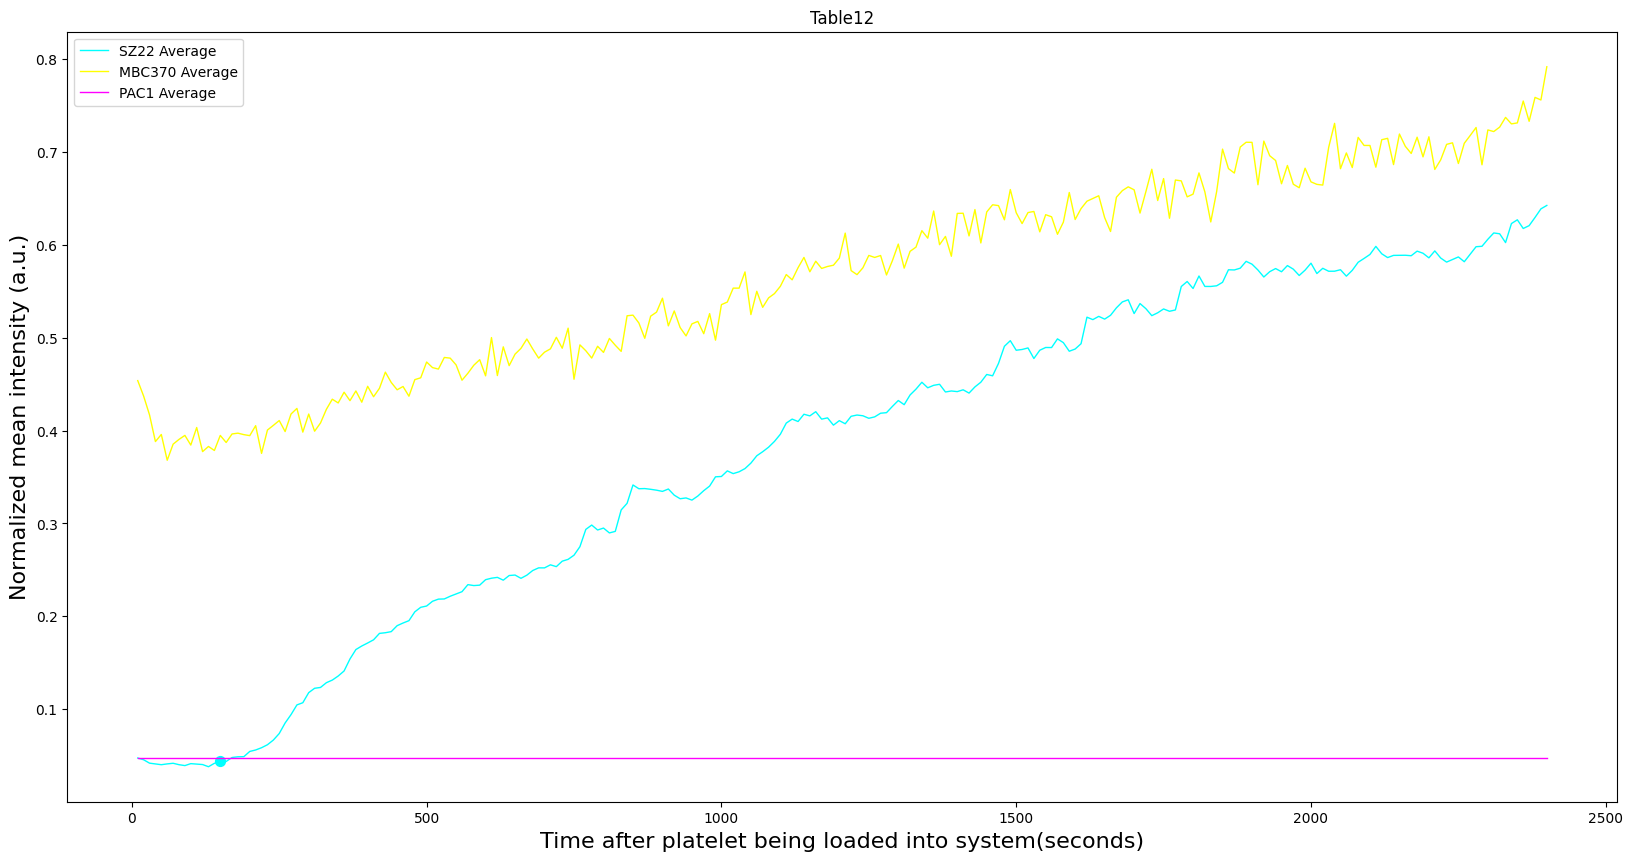

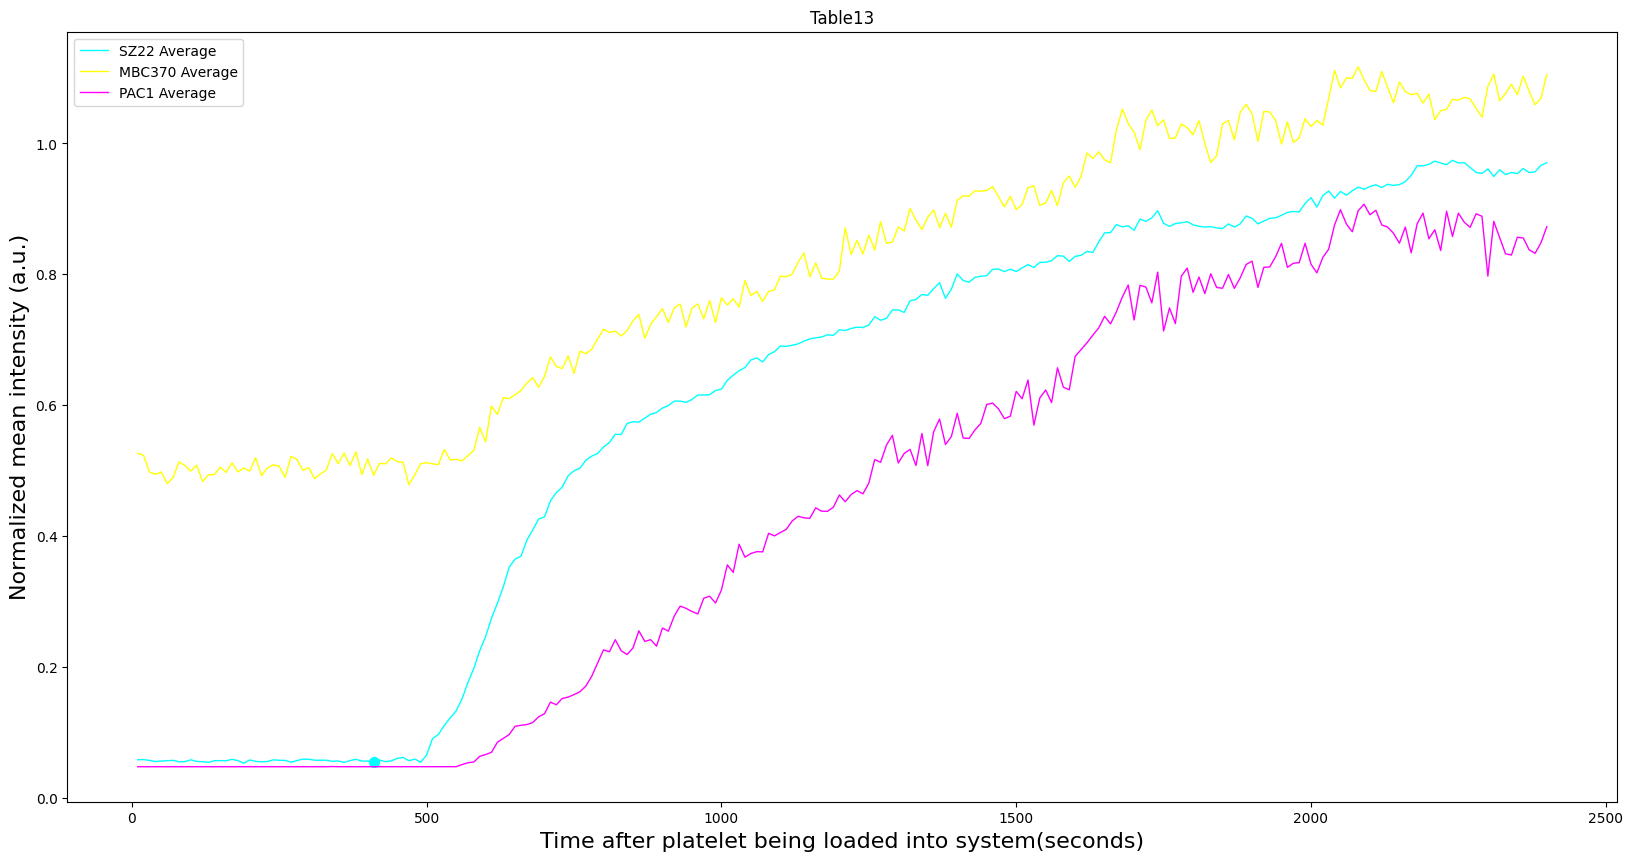

In [51]:
# 找到,并检查 -- 拐点
from kneed import KneeLocator

# 初始化新列表,用于收集拐点
knee_y1_alls = []
knee_y2_alls = []
knee_y3_alls = []

for table_number, df in table_data.items():
    y1 = df["SZ22 Normalization"]
    y2 = df["MBC370 Normalization"]
    y3 = df["PAC1 Normalization"]
    x = df["Time"]
 
# Search: what function in python can make a noisy curve smoother--
# Savitzky-Golay 平滑滤波器，函数scipy.signal.savgol_filter（）； tolist转化为一维数据； 
# window_length=10,左右各10个点进行拟合；polyorder = 2，second-degree polynomial (a quadratic curve) 曲线
    y1_smooth = scipy.signal.savgol_filter(ny.array(y1.tolist()),30,1)
#     y2_smooth = scipy.signal.savgol_filter(ny.array(y2.tolist()),4,1)
#     y3_smooth = scipy.signal.savgol_filter(ny.array(y3.tolist()),30,4)
    
# knee_y --> The x value of the knee point
# 不能直接用x,y，因为xy是2维的table，函数kneeLocar需要input列表类型，用tolist转化为1维列表 , 
# online默认false，如果不改为ture，不能进行自我矫正，仅保留找到的第一个拐点
# knee_y1是kneelocator函数的对象，需要找xy.plot索引值时应该加.knee
    knee_y1 = KneeLocator(x.tolist(), y1_smooth.tolist(), S=1, curve = 'convex', direction = 'increasing', online = True, interp_method="interp1d")
#     knee_y2 = KneeLocator(x.tolist(), y2_smooth.tolist(), S=1, curve = 'convex', direction = 'increasing', online = True)    
#     knee_y3 = KneeLocator(x.tolist(), y3_smooth.tolist(), S=1, curve = 'convex', direction = 'increasing', online = True)  
        
# knee_y.knee 输出对应拐点“x”值，在原图中画点需找到对应的y值    
    knee_x1 = ny.where(x.values == knee_y1.knee)
#     knee_x2 = ny.where(x.values == knee_y2.knee)
#     knee_x3 = ny.where(x.values == knee_y3.knee)
    
# plot
    plt.figure(figsize=(20,10))
    plt.plot(x,y1, c='cyan',label='SZ22 Average',linewidth=1.0)
    plt.plot(x,y2,c='yellow',label = 'MBC370 Average',linewidth=1.0)
    plt.plot(x,y3,c='magenta',label = 'PAC1 Average',linewidth=1.0)    
    plt.xlabel("Time after platelet being loaded into system(seconds)", fontdict={'size': 16})
    plt.ylabel("Normalized mean intensity (a.u.)", fontdict={'size': 16})
    plt.title(table_number)
    plt.legend(loc = 'best')      
# plot_knee()；x = knee_y1.knee, y= y1[knee_x1[0]]
# y1[knee_x1[0]] y1中获取knee_x1的第一个元素，索引[0]对应的元素
    plt.scatter(knee_y1.knee, y1[knee_x1[0]], c='cyan', marker='o',s=50,label='knee point')
#     plt.scatter(knee_y2.knee, y2[knee_x2[0]], c='yellow',marker='o',s=50,label='knee point')
#     plt.scatter(knee_y3.knee, y3[knee_x3[0]], c='magenta',marker='o',s=50,label='knee point')
    
# # 用append方法填入knee_y_all列表中 
    knee_y1_alls.append(knee_y1.knee / 10)
#     knee_y2_alls.append(knee_y2.knee / 10)
#     knee_y3_alls.append(knee_y3.knee / 10)

print(knee_y1_alls)
# print(knee_y2_alls)
# print(knee_y3_alls)
knee_y1_avg = ny.mean(knee_y1_alls) 
print(knee_y1_avg)

In [52]:
# 自动找到起始点和结束点，并且返回截取的有效数据
def FindStartEndPoint(Target):
    TargetNP = ny.array(Target)
    StartPoint = -1
    EndPoint = -1

    for i in range(TargetNP.size):
        if ny.isnan(TargetNP[i])==False:
            StartPoint = i
            break
            
    for j in range(StartPoint,TargetNP.size):
        if ny.isnan(TargetNP[j])==True:
            EndPoint = j 
            break
            
    ProcessedTarget = Target[StartPoint:EndPoint]
    return ProcessedTarget

In [53]:
# 平移曲线，求平均

knee_y1_avg = ny.mean(knee_y1_alls) 
print(knee_y1_avg)

i = 0
merged_SZ22 = pd.DataFrame()
merged_MBC370 = pd.DataFrame()
merged_PAC1 =pd.DataFrame()

# SZ22 = pd.DataFrame(index=df.index, columns=df.columns)

for table_number, df in table_data.items():   
    
# 扩大df为原来的三倍，上下都加NaN值    
    empty_df = pd.DataFrame(index=df.index, columns=df.columns)
    df_expand = pd.concat([empty_df, df, empty_df])
    
# 按照SZ22的转折点平移曲线       
    if knee_y1_alls[i] > knee_y1_avg:
        df_expand = df_expand.shift(int(-abs(knee_y1_alls[i] - knee_y1_avg)))
    else:
        df_expand = df_expand.shift(int(abs(knee_y1_alls[i] - knee_y1_avg)))
        
    i = i + 1
#     print(df_expand.iloc[310]) 
    
# print(df_expand.iloc[310])           
    merged_SZ22 = pd.concat([merged_SZ22, df_expand["SZ22 Normalization"]],axis=1)
    merged_MBC370 = pd.concat([merged_MBC370,df_expand["MBC370 Normalization"]], axis=1)
    merged_PAC1 = pd.concat([merged_PAC1,df_expand["PAC1 Normalization"]], axis=1)
    
   
    

# print(merged_SZ22.iloc[310])
#  通过平均值合并y1,y2,y3       
merged_SZ22_mean = merged_SZ22.mean(axis =1)
merged_MBC370_mean = merged_MBC370.mean(axis =1)
merged_PAC1_mean = merged_PAC1.mean(axis =1)

y1_avg =  merged_SZ22_mean
y2_avg =  merged_MBC370_mean
y3_avg =  merged_PAC1_mean
x = df_expand["Time"]

TargetY = ny.array(y1_avg)
StartPoint = -1
for i in range(TargetY.size):
        if ny.isnan(TargetY[i])==False:
            StartPoint = i
            break

# 设置x
Vaild_y1_avg = ny.array(FindStartEndPoint(y1_avg))
x_size = Vaild_y1_avg.size 
Vaild_x_Con_Zeros = ny.arange(- knee_y1_avg* 10 - i*10 -10, x_size * 10 + knee_y1_avg* 10,10)
Times = pd.Series(Vaild_x_Con_Zeros)
Times.name = 'Times'

merged_SZ22 = merged_SZ22.reset_index(drop=True)
merged_MBC370 = merged_MBC370.reset_index(drop=True)
merged_PAC1 = merged_PAC1.reset_index(drop=True)

# Step 2: Rename columns of merged_SZ22, merged_MBC370, and merged_PAC1 to make them distinct
merged_SZ22.columns = [f'SZ22_Normalization{i}' for i in range(1, len(merged_SZ22.columns) + 1)]
merged_MBC370.columns = [f'MBC370_Normalization{i}' for i in range(1, len(merged_MBC370.columns) + 1)]
merged_PAC1.columns = [f'PAC1_Normalization{i}' for i in range(1, len(merged_PAC1.columns) + 1)]

# Step 3: Add empty columns between each DataFrame
empty_column = pd.Series('', index=Times.index)

merged = pd.concat([Times, merged_SZ22, empty_column, merged_MBC370,empty_column, merged_PAC1], axis=1)

# Now, you can write the combined DataFrame 'merged' to Excel
# merged.to_excel(r'C:\Users\coco\Desktop\0813\0813-s0-2-v1-output.xlsx', index=False)


65.76923076923077


In [44]:
TargetY = ny.array(y1_avg)
StartPoint = -1
for i in range(TargetY.size):
        if ny.isnan(TargetY[i])==False:
            StartPoint = i
            break


In [46]:
i

199

In [11]:
# 设置x
Vaild_y1_avg = ny.array(FindStartEndPoint(y1_avg))
x_size = Vaild_y1_avg.size 
Vaild_x_Con_Zeros = ny.arange(- knee_y1_avg* 10 , x_size * 10 + knee_y1_avg* 10,10)

In [9]:
Vaild_x = ny.array(FindStartEndPoint(x))
Vaild_y1_avg = ny.array(FindStartEndPoint(y1_avg))
Vaild_y2_avg = ny.array(FindStartEndPoint(y2_avg))
Vaild_y3_avg = ny.array(FindStartEndPoint(y3_avg))

# 设置x
x_size = Vaild_y1_avg.size 
Vaild_x_Con_Zeros = ny.arange(0,x_size * 10 ,10)

# 置信区间
merged_SZ22_num = merged_SZ22.count(axis =1)
merged_MBC370_num = merged_MBC370.count(axis =1)
merged_PAC1_num = merged_PAC1.count(axis =1)

merged_SZ22_std = ny.std(merged_SZ22, axis =1)
merged_MBC370_std = ny.std(merged_MBC370,axis =1)
merged_PAC1_std = ny.std(merged_PAC1,axis =1)

low_ci1 = merged_SZ22_mean - 0.95 * (merged_SZ22_std / ny.sqrt(merged_SZ22_num))
high_ci1 = merged_SZ22_mean + 0.95 * (merged_SZ22_std / ny.sqrt(merged_SZ22_num))
low_ci2= merged_MBC370_mean - 0.95 * (merged_MBC370_std / ny.sqrt(merged_MBC370_num))
high_ci2 = merged_MBC370_mean + 0.95 * (merged_MBC370_std / ny.sqrt(merged_MBC370_num))
low_ci3= merged_PAC1_mean - 0.95 * (merged_PAC1_std / ny.sqrt(merged_PAC1_num))
high_ci3 =merged_PAC1_mean + 0.95 * (merged_PAC1_std / ny.sqrt(merged_PAC1_num))

Vaild_low_ci1 = FindStartEndPoint(low_ci1)
Vaild_low_ci2 = FindStartEndPoint(low_ci2)
Vaild_low_ci3 = FindStartEndPoint(low_ci3)
Vaild_high_ci1 = FindStartEndPoint(high_ci1)
Vaild_high_ci2 = FindStartEndPoint(high_ci2)
Vaild_high_ci3 = FindStartEndPoint(high_ci3)

Vaild_low_ci1 = Vaild_low_ci1.fillna(0)
Vaild_high_ci1 =Vaild_high_ci1.fillna(0)
Vaild_low_ci2 = Vaild_low_ci2.fillna(0)
Vaild_high_ci2 =Vaild_high_ci2.fillna(0)
Vaild_low_ci3 = Vaild_low_ci3.fillna(0)
Vaild_high_ci3 =Vaild_high_ci3.fillna(0)

# Vaild_x_Con_Zeros = Vaild_x_Con_Zeros.fillna(0)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
# 画图
plt.figure(figsize=(20,10))
plt.plot(Vaild_x_Con_Zeros,Vaild_y1_avg, c='cyan',label='SZ22 Average',linewidth=1.0)
plt.plot(Vaild_x_Con_Zeros,Vaild_y2_avg, c='yellow',label='MBC370 Average',linewidth=1.0)
plt.plot(Vaild_x_Con_Zeros,Vaild_y3_avg , c='magenta',label='PAC1 Average',linewidth=1.0)

plt.xlabel("Time after platelet being loaded into system(seconds)", fontdict={'size': 16})
plt.ylabel("Normalized mean intensity (a.u.)", fontdict={'size': 16})
plt.legend(loc = 'best')

# assert ny.all(ny.isfinite(Vaild_low_ci1)& ny.isfinite(Vaild_high_ci1) & ny.isfinite(Vaild_low_ci2) & ny.isfinite(Vaild_high_ci2) & ny.isfinite(Vaild_low_ci3)& ny.isfinite(Vaild_high_ci3))

plt.fill_between(Vaild_x_Con_Zeros, Vaild_low_ci1, Vaild_high_ci1, alpha=0.15, facecolor='cyan')
plt.fill_between(Vaild_x_Con_Zeros, Vaild_low_ci2, Vaild_high_ci2, alpha=0.15,facecolor='yellow')
plt.fill_between(Vaild_x_Con_Zeros, Vaild_low_ci3, Vaild_high_ci3, alpha=0.15,facecolor='magenta')

# 调整xy格式
plt.xticks(range(0,1600,400))
plt.ylim(0, 1)
plt.title("0916-S2", fontdict={'size':20})